In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from pathlib import Path

In [2]:
import sys

sys.path.append(str(Path("..").resolve()))

from src.output_creator import OutputCreator
from src.graficador import Graficador

In [3]:
ROOT_DIR = Path.cwd().parent 

ruta_datos = ROOT_DIR / "data" / "spotify_songs.csv"

ruta_graficos = ROOT_DIR / "outputs" / "graficos"

ruta_tablas = ROOT_DIR / "outputs" / "tablas"

df = pd.read_csv(ruta_datos)

In [4]:
saver = OutputCreator(ruta_tablas, ruta_graficos)
graficas = Graficador(ruta_graficos)

In [5]:
variables_irrelevantes = ["track_id", "track_album_id", "playlist_id", "liveness"]
df = df.drop(columns=variables_irrelevantes)

In [6]:
df_size = len(df)
df_size

32833

# Fase 1: Comprensión del negocio

## Contexto

El gerente de una disquera desea conocer mejor el mercado musical contemporaneo para seleccionar de mejor manera a que clase de artistas fimar segun lo popular que es su estilo musical.

---

## Objetivo de Negocio

Incrementar la popularidad de los artistas firmados por la disquera.

---

## Objetivo del Proyecto de Datos

Identificar que clase de caracteristicas musicales y de percepcion de los usuarios generan una mayor popularidad en las canciones (ritmo, energia, genero, etc)

---

## KPIs (Indicadores Clave)

* Incrementar el índice de popularidad promedio (0-100) de los nuevos artistas firmados en un 30% en un plazo de 8 meses basado en las recomendaciones.
* Incrementar el ingreso medio por streaming provenientes de los artistas en un 20% en los proximos 12 meses.
---

# Fase 2: Comprensión De Los Datos


## 2.1 Diccionario de Datos:

| variable | class | description |
| :--- | :--- | :--- |
| `track_name` | character (categorica nominal) | Nombre de la canción |
| `track_artist` | character (categorica nominal) | Artista |
| `track_album_name` | character (categorica nominal) | Nombre del Album |
| `playlist_name` | character (categorica nominal) | Nombre de la playlist |
| `playlist_genre` | character (categorica nominal) | Genero de la playlist |
| `playlist_subgenre` | character (categorica nominal) | Subgenero de la playlist |
| `mode` | double (categorica nominal) | El modo indica la modalidad (mayor o menor) de una pista, el tipo de escala de la que se deriva su contenido melódico. El mayor se representa con 1 y el menor con 0. |
| `key` | double (preparada numericamente), en el negocio es character (categorica nominal) | La tonalidad general estimada de la pista. Los números enteros se asignan a tonos utilizando la notación estándar de clases de tono. Por ejemplo, 0 = C, 1 = C♯/D♭, 2 = D, y así sucesivamente. Si no se detecta ninguna tonalidad, el valor es -1. |
| `track_popularity` | double (cuantitativa continua) | Popularidad de la canción (0-100) minetras mas alta sea mejor |
| `danceability` | double (cuantitativa continua) | La **danceability** o **bailabilidad** describe la idoneidad de una pista para bailar según una combinación de elementos musicales, como el tempo, la estabilidad rítmica, la intensidad del compás y la regularidad general. Un valor de 0.0 es el menos bailable y 1.0 el más bailable. |
| `energy` | double (cuantitativa continua) | La energía es una medida de 0.0 a 1.0 y representa una medida perceptual de intensidad y actividad. Normalmente, las pistas energéticas se perciben rápidas, fuertes y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características perceptuales que contribuyen a este atributo incluyen el rango dinámico, la sonoridad percibida, el timbre, la velocidad de inicio y la entropía general. |
| `tempo` | double (cuantitativa continua) | El tempo general estimado de una pista en pulsaciones por minuto (BPM). En terminología musical, el tempo es la velocidad o el ritmo de una pieza determinada y se deriva directamente de la duración media de los compases. |
| `duration_ms` | double (cuantitativa continua) | Duración de la canción en milisegundos |
| `loudness` | double (cuantitativa continua) | La sonoridad general de una pista en decibelios (dB). Los valores de sonoridad se promedian en toda la pista y son útiles para comparar la sonoridad relativa de las pistas. La sonoridad es el volumen percibido por el oído humano a lo largo del tiempo, independientemente de la potencia real de los altavoces. Los valores suelen oscilar entre -60 y 0 db. |
| `speechiness` | double (cuantitativa continua) | La "speechiness" detecta la presencia de palabras habladas en una pista. Cuanto más exclusivamente parecida al habla sea la grabación (por ejemplo, un programa de entrevistas, un audiolibro, poesía), más cerca de 1.0 estará el valor del atributo. Los valores superiores a 0.66 describen pistas que probablemente estén compuestas en su totalidad por palabras habladas. Los valores entre 0.33 y 0.66 describen pistas que pueden contener tanto música como habla, ya sea en secciones o en capas, incluyendo casos como la música rap. Los valores inferiores a 0.33 representan probablemente música y otras pistas que no son de tipo habla. |
| `acousticness` | double (cuantitativa continua) | Una medida de confianza de 0.0 a 1.0 sobre si la pista es acústica. 1.0 representa una confianza alta de que la pista es acústica. |
| `instrumentalness` | double (cuantitativa continua) | Predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" se tratan como instrumentales en este contexto. Las pistas de rap o de palabras habladas son claramente "vocales". Cuanto más cercano a 1.0 sea el valor de instrumentalidad, mayor será la probabilidad de que la pista no contenga contenido vocal. Los valores superiores a 0.5 están destinados a representar pistas instrumentales, pero la confianza es mayor a medida que el valor se acerca a 1.0. |
| `valence` | double (cuantitativa continua) | Una medida de 0.0 a 1.0 que describe la positividad musical transmitida por una pista. Las pistas con una valencia alta suenan más positivas (por ejemplo, felices, alegres, eufóricas), mientras que las pistas con una valencia baja suenan más negativas (por ejemplo, tristes, deprimidas, enfadadas). |

<p align="left">
  <small><b>Tabla 1:</b> Diccionario de datos adaptado de <a href="https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs">30,000 Spotify Songs</a> por <a href="https://www.kaggle.com/joebeachcapital">Joakim Arvidsson</a>. Clasificación estadística añadida por el equipo de trabajo.</small>
</p>

---
## 2.2 Relevancia
Todas aquellas variables relevantes para el objetivo ya estan incluidas en el diccionario de datos, aquellas que no son utiles para el objetivo se omitieron en la tabla presentada. Dichas variables son utiles en el contexto, pues describen tanto caracteristicas propias de las pistas de audio como tambien sus metadatos (ej: artista), este conjunto de datos sera util para generar varias asociaciónes, correlaciones o establecer relaciones entre variables categoricas y numericas, de esta manera permitiendo al equipo de investigación extraer insights estratégicos para el negocio.




## 2.3 Diagnostico inicial de calidad

### 2.3.1 Identificación de nulos y su proporción

In [7]:
columnas_con_nulos = df.isna().sum().to_frame(name='Total_Nulos')
columnas_con_nulos

,Total_Nulos
track_name,5
track_artist,5
track_popularity,0
track_album_name,5
track_album_release_date,0
playlist_name,0
playlist_genre,0
playlist_subgenre,0
danceability,0
energy,0


Solo 3 variables tienen valores nulos (`track_name`, `track_artist` y `track_album_name`), ademas es una proporcion realmente baja de nulos, a lo sumo hay una proporcion de $\frac{15}{32833}$ registros con nulos, lo cual correstponde a tan solo el **$ 0.0456\%$** de la muestra

In [8]:
saver.guardar_csv(columnas_con_nulos, "columnas_con_nulos.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\columnas_con_nulos.csv
Operación cancelada para evitar duplicados.


In [9]:
registros_nulos = df[df.isnull().any(axis=1)]
registros_nulos

,track_name,track_artist,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms
8151,NaN,NaN,0,NaN,2012-01-05,HIP&HOP,rap,southern hip hop,0.714,0.821,6,-7.635,1,0.1760,0.0410,0.00000,0.649,95.999,282707
9282,NaN,NaN,0,NaN,2017-12-01,GANGSTA Rap,rap,gangster rap,0.678,0.659,11,-5.364,0,0.3190,0.0534,0.00000,0.191,146.153,202235
9283,NaN,NaN,0,NaN,2017-12-01,GANGSTA Rap,rap,gangster rap,0.465,0.820,10,-5.907,0,0.3070,0.0963,0.00000,0.505,86.839,206465
19568,NaN,NaN,0,NaN,2012-01-05,Reggaeton viejito🔥,latin,reggaeton,0.675,0.919,11,-6.075,0,0.0366,0.0606,0.00653,0.726,97.017,252773
19811,NaN,NaN,0,NaN,2012-01-05,latin hip hop,latin,latin hip hop,0.714,0.821,6,-7.635,1,0.1760,0.0410,0.00000,0.649,95.999,282707


In [10]:
saver.guardar_csv(registros_nulos, "registros_nulos.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\registros_nulos.csv
Operación cancelada para evitar duplicados.


Los 5 nulos que se observaron en cada una de las tres variables mencionadas anteriormente pertenecen a lo mismos registros, por lo que solo el $0.01522 \%$ de los registros de la base de datos contiene nulos, una proporción despreciable. La mejor opción a futuro será la eliminación.

### 2.3.2 Revisión de formatos incosistentes

In [11]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_name                32828 non-null  str    
 1   track_artist              32828 non-null  str    
 2   track_popularity          32833 non-null  int64  
 3   track_album_name          32828 non-null  str    
 4   track_album_release_date  32833 non-null  str    
 5   playlist_name             32833 non-null  str    
 6   playlist_genre            32833 non-null  str    
 7   playlist_subgenre         32833 non-null  str    
 8   danceability              32833 non-null  float64
 9   energy                    32833 non-null  float64
 10  key                       32833 non-null  int64  
 11  loudness                  32833 non-null  float64
 12  mode                      32833 non-null  int64  
 13  speechiness               32833 non-null  float64
 14  acousticness     

todas las variables tienen el Dtype adecuado

### 2.4 Detección de registros duplicados.

En este caso se consideran duplicados registros de canciones que repiten nombre y autor, y la unica diferencia que presentan es la playlist de la cual fueron tomadas desde la API, es decir son la misma cancion, solo que tomada de una playlist diferente

In [12]:
duplicados = df.duplicated(subset=['track_name', 'track_artist'], keep='first')

df_duplicados = df[duplicados]
ejemplo_de_canciones_duplicadas = df_duplicados[df_duplicados['track_name'] == 'Callaita']
ejemplo_de_canciones_duplicadas

,track_name,track_artist,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms
11135,Callaita,Bad Bunny,90,Callaita,2019-05-31,Trap 2020 🔥,rap,trap,0.61,0.624,2,-4.773,1,0.309,0.6,0.000002,0.244,176.169,250534
17872,Callaita,Bad Bunny,90,Callaita,2019-05-31,LATIN POP 2020 🔥 Pop latino actual,latin,latin pop,0.61,0.624,2,-4.773,1,0.309,0.6,0.000002,0.244,176.169,250534
18816,Callaita,Bad Bunny,90,Callaita,2019-05-31,Mansión Reggaetón,latin,reggaeton,0.61,0.624,2,-4.773,1,0.309,0.6,0.000002,0.244,176.169,250534
20282,Callaita,Bad Bunny,90,Callaita,2019-05-31,Urbano: Latino Vibes,latin,latin hip hop,0.61,0.624,2,-4.773,1,0.309,0.6,0.000002,0.244,176.169,250534
21893,Callaita,Bad Bunny,90,Callaita,2019-05-31,Chixtape 5 - Tory Lanez,r&b,urban contemporary,0.61,0.624,2,-4.773,1,0.309,0.6,0.000002,0.244,176.169,250534


In [13]:
saver.guardar_csv(ejemplo_de_canciones_duplicadas, 'ejemplo_de_canciones_duplicadas.csv')

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\ejemplo_de_canciones_duplicadas.csv
Operación cancelada para evitar duplicados.


Vea que la cancion *Callaita* se repite numerosas veces en los registros, sin embargo la unica diferencia entre estas ocurrencias radica en su playlist de origen. A futuro se sugioere dejar solo un registro y agregar la variable ocurrencias en playlists para no perder esta información, o alternativamente en una variable "playlists" agregar una cadena que contenga todas las playlist que contienen la cancion, logrando de esta manera un solo registro por pista.

In [14]:
len(df_duplicados)

6603

En total hay 6603 canciones duplicadas en la base de datos (solo se tomaron en cuenta las ocurrencias sin incluir la primera fila, esa no se toma como duplicado)

## 3 EDA

## 3.1 Analisis Univariado

### 3.1.1 Variables categoricas.

#### track_name                

In [15]:
len(df['track_name'].unique())

23450

In [16]:
df['track_name'].mode()

0    Poison
Name: track_name, dtype: str

hay 23450 valores unicos, no vale la pena graficar esta varibale, el titulo mas comun en canciones es Poison (probablemente alguna cancion con ese nombre se repite varias veces en la base de datos)

#### track_artist

In [17]:
len(df['track_artist'].unique())

10693

In [18]:
df['track_artist'].mode()

0    Martin Garrix
Name: track_artist, dtype: str

In [19]:
# Agrupar por artista y calcular media y conteo a la vez
stats_artistas = df.groupby("track_artist")["track_popularity"].agg(['mean', 'count'])

# Filtrar artistas con al menos 30 canciones
top_artistas = stats_artistas[stats_artistas['count'] >= 25].sort_values(by='mean', ascending=False).reset_index()
top_10_artistas = top_artistas.head(10)

top_10_artistas

,track_artist,mean,count
0,Harry Styles,83.592593,27
1,Billie Eilish,83.581395,43
2,Travis Scott,82.147059,34
3,Camila Cabello,77.105263,38
4,Dua Lipa,75.793103,29
5,Khalid,75.298246,57
6,AC/DC,74.892857,28
7,Ed Sheeran,74.231884,69
8,Justin Bieber,74.225806,31
9,Selena Gomez,72.288462,52


De los 10693 artistas distintos que contiene la base de datos el que mas suele repetirse es Martin Garrix, probablemente sus canciones tengan alta presencia en playlists

#### track_album_name

In [20]:
len(df['track_album_name'].unique())

19744

In [21]:
df['track_album_name'].mode()

0    Greatest Hits
Name: track_album_name, dtype: str

de los 19744 albumnes distintos el que mas se repite es una compilacion de *Greatest Hits*

#### playlist_genre

In [22]:
len(df['playlist_genre'].unique())

6

In [23]:
print(f"generos musicales considerados: {list(df['playlist_genre'].unique())}")

generos musicales considerados: ['pop', 'rap', 'rock', 'latin', 'r&b', 'edm']


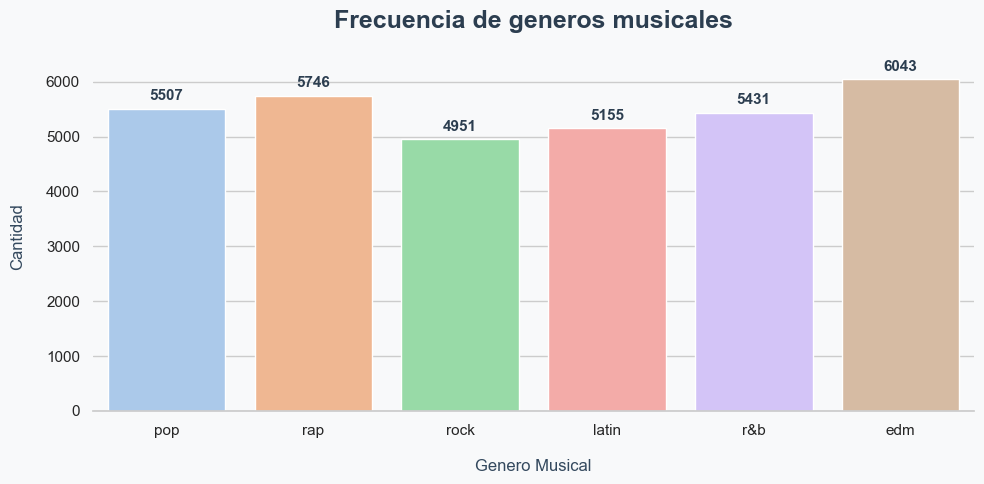

In [24]:
graficas.barplot_discreto(df, "playlist_genre", titulo="Frecuencia de generos musicales", etiqueta_x="Genero Musical", order=False)

De los generos musicales considerados, el que suele repetirse mas como genero principal de una playlist es el **edm**, y el que posee menos playlists es el **rock** , sin embargo la diferencia entre la frecuencia de playlists de cada genero no es extremadamente diferente.

In [25]:
graficas.guardar_grafico('Frecuencia de generos musicales')

El archivo 'Frecuencia de generos musicales.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


#### playlist_subgenre

In [26]:
print(f"subgeneros musicales considerados: {list(df['playlist_subgenre'].unique())}")

subgeneros musicales considerados: ['dance pop', 'post-teen pop', 'electropop', 'indie poptimism', 'hip hop', 'southern hip hop', 'gangster rap', 'trap', 'album rock', 'classic rock', 'permanent wave', 'hard rock', 'tropical', 'latin pop', 'reggaeton', 'latin hip hop', 'urban contemporary', 'hip pop', 'new jack swing', 'neo soul', 'electro house', 'big room', 'pop edm', 'progressive electro house']


In [27]:
len(df['playlist_subgenre'].unique())

24

Hay 24 subgeneros posibles

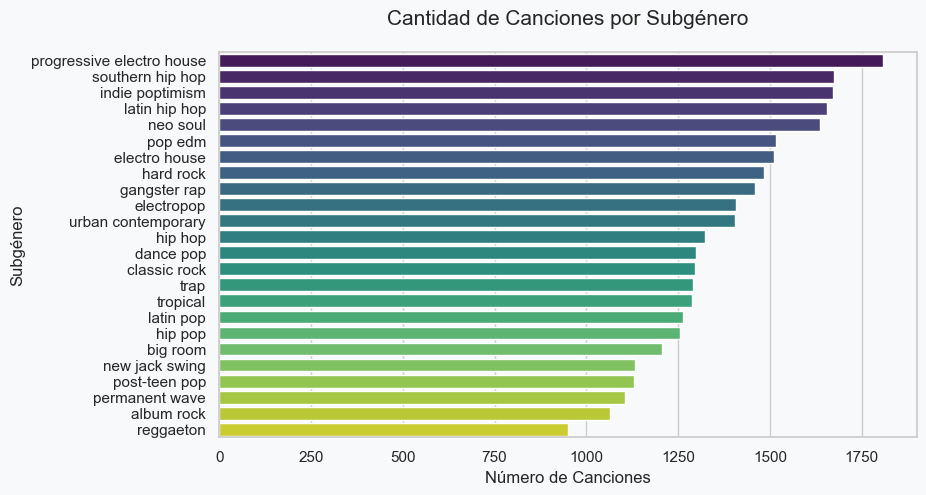

In [28]:

conteo_generos = df['playlist_subgenre'].value_counts()

plt.figure(figsize=(9, 5))

sns.barplot(
    x=conteo_generos.values,  # Los números (frecuencia)
    y=conteo_generos.index,   # Los nombres de los subgéneros
    palette='viridis',
    hue=conteo_generos.index
)


plt.title('Cantidad de Canciones por Subgénero', fontsize=15, pad=20)
plt.xlabel('Número de Canciones', fontsize=12)
plt.ylabel('Subgénero', fontsize=12)

plt.show()

El subgenero mas comun es **progresive electro house** y el menos comun el **reggaeton** (probablemente porque los datos al ser tomados por un angloparlante, tomo menos en cosideracion dicho genero, ya que es propiamente de habla hispana), esta variable considera mas grupos que los generos principales, lo cual puede ser interesante para separar de manera mas exacta las canciones, sin embargo puede ser engorroso trabajar con 24 grupos, mas adelante se desidira como es mejor separar las canciones.

In [29]:
def entropia(var):
    conteos = df[var].value_counts()

    probabilidades = conteos / conteos.sum()

    ent = stats.entropy(probabilidades, base=2)

    print(f"La entropía de la variable es: {ent:.4f} ")

entropia('playlist_subgenre')

La entropía de la variable es: 4.5668 


La entropia es alta por lo que no hay ninguna clase que sea especialemente probable, lo cual indica que la variable esta equilibrada.

#### Mode (modo)

In [30]:
modos = {0:'menor',
         1: 'mayor'}

df['mode str'] = df['mode'].map(modos)

In [31]:
df['mode str'].value_counts()

mode str
mayor    18574
menor    14259
Name: count, dtype: int64

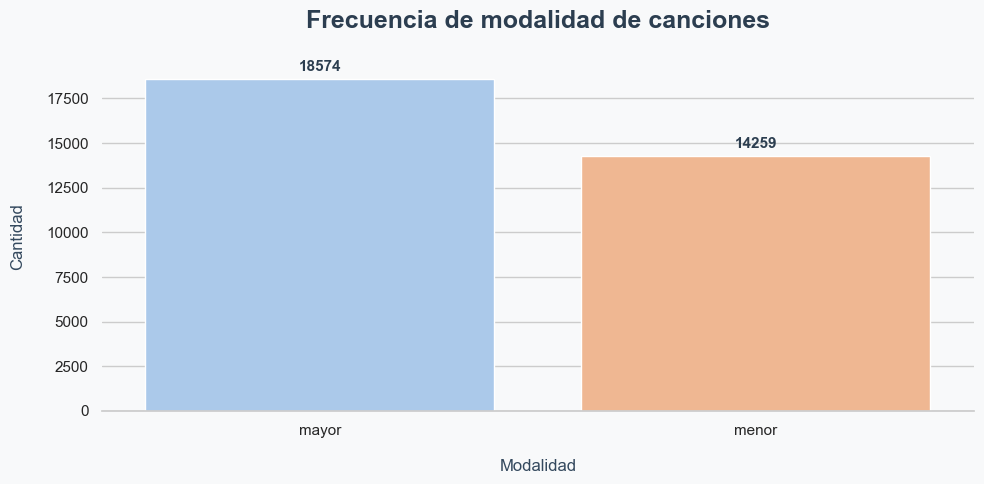

In [32]:
graficas.barplot_discreto(df, "mode str", titulo="Frecuencia de modalidad de canciones", etiqueta_x="Modalidad", order=False)

Por lo general las canciones estan en modalidad mayor. Las cual suele asociarse con emociones como felicidad, alegría, optimismo, triunfo y energía. Ademas de ser comunes en composiciones pop y musica comercial.

In [33]:
graficas.guardar_grafico("Frecuencia de modalidad de canciones")

El archivo 'Frecuencia de modalidad de canciones.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


#### Key (tonalidad)

In [34]:
df['key'].unique()

array([ 6, 11,  1,  7,  8,  5,  4,  2,  0, 10,  9,  3])

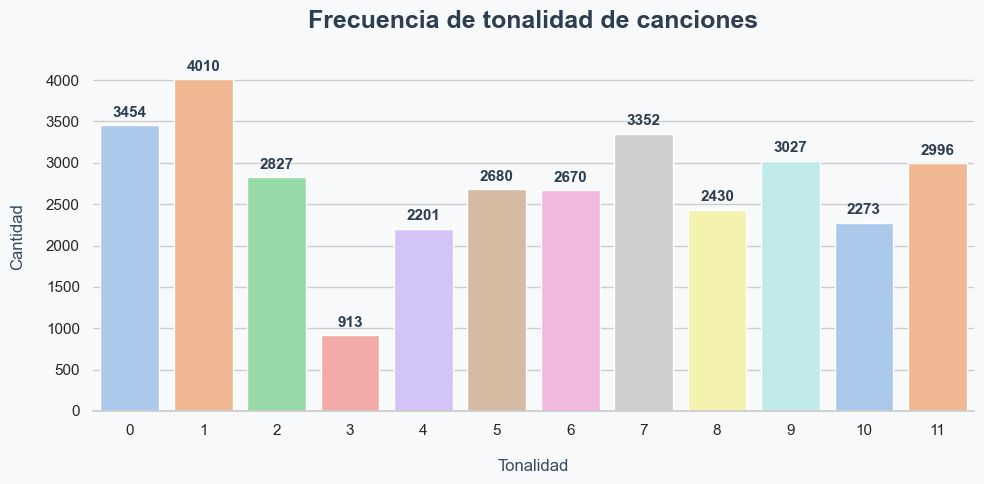

In [35]:
graficas.barplot_discreto(df, "key", titulo="Frecuencia de tonalidad de canciones", etiqueta_x="Tonalidad", order=False)

### Variables numericas 

#### danceability (bailabilidad)

La **danceability** o **bailabilidad** describe la idoneidad de una pista para bailar según una combinación de elementos musicales, como el tempo, la estabilidad rítmica, la intensidad del compás y la regularidad general. Un valor de 0.0 es el menos bailable y 1.0 el más bailable. 

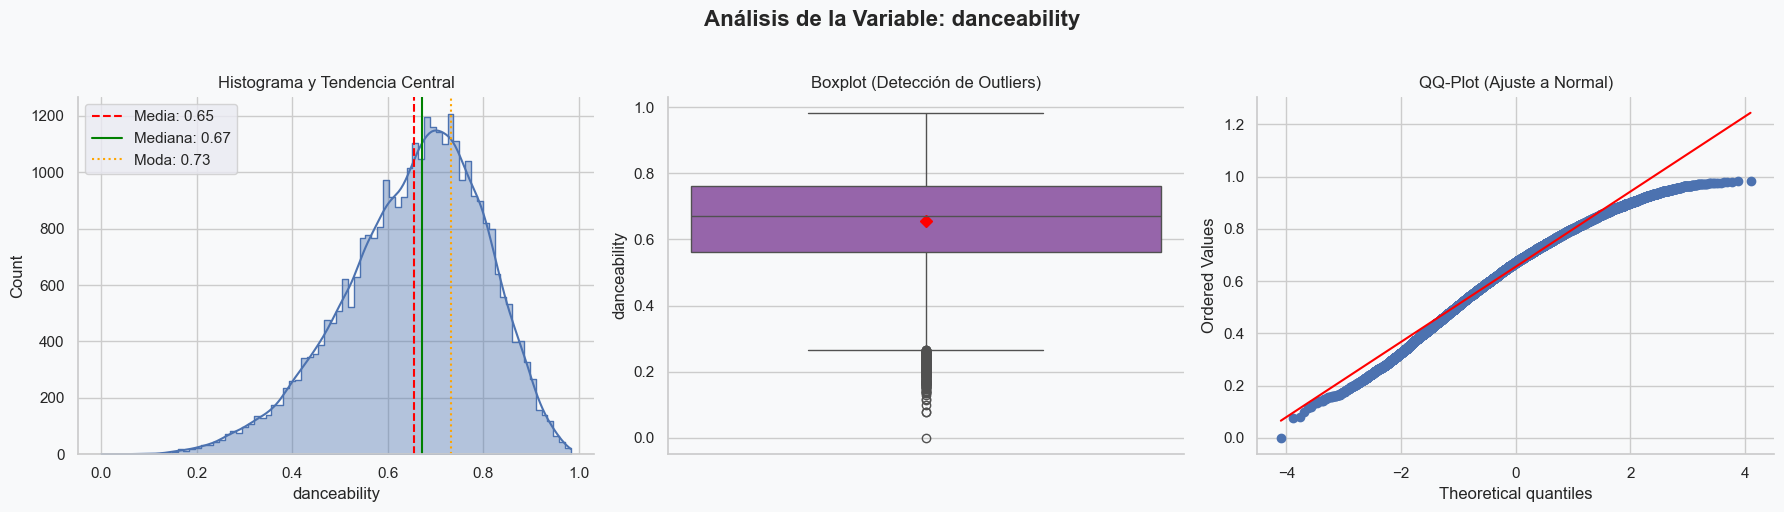

In [36]:
graficas.graficos_continuos(df, "danceability")

In [37]:
graficas.guardar_grafico("distribucion de danceability")

El archivo 'distribucion de danceability.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [38]:
def resumen_numerico(var, screen = True) -> pd.DataFrame:

    """Analiza la normalidad, media, mediana y variacion de una variable.
        Retornara un diccionario
    """
    datos = df[var].dropna()

    largo = len(datos)
    std = float(datos.std())
    mean = float(datos.mean())
    median = float(datos.median())

    #medidas de forma
    sk = float(datos.skew())

    if sk > 0.5:
        forma = "Sesgo positivo (derecha)"
    elif sk < -0.5:
        forma = "Sesgo negativo (izquierda)"
    else:
        forma = "Simétrica"
    
    curtosis = float(datos.kurt())
    if curtosis > 0.5:
        forma_curt = "leptocurtica"
    elif curtosis < -0.5:
        forma_curt = "platicurtica"
    else:
        forma_curt = "mesocurtica"

    q1 = datos.quantile(0.25)
    q3 = datos.quantile(0.75)


    iqr = q3 - q1

    LS = q3 + 1.5*iqr
    LI = q1 - 1.5*iqr
    if screen:
        print(f"media: {mean}\nmediana: {median}")
        print(f"std: {std}\ntamaño muestra: {largo}\n")
        print(f"asimetria: {sk}\nsesgo: {forma}\n")
        print(f"curtosis: {curtosis}\nforma: {forma_curt}\n")

        print(f"intervalo: [{q1}, {q3}]")
        print(f"IQR: {iqr}\n")
        print(f"intervalo de valores no atipicos segun IQR: [{LI}, {LS}]")
        print("-"*40,"\n")



    if largo > 50:
        d_stat, p_valor = stats.kstest(datos, 'norm', args=(datos.mean(), datos.std()))
        if screen:
            print(f"Estadístico Kolgomorov-Smirnov: {d_stat:.4f}")

            print(f"Valor p: {p_valor}")
    else:

        stat, p_valor = stats.shapiro(datos)
        if screen:
            print(f"Estadístico W: {stat:.4f}")
            print(f"Valor p: {p_valor:.4f}\n")

    alpha = 0.05
    if screen:
        if p_valor > alpha:
            print("\nNo se rechaza H0: Los datos provienen de una población normal")
        else:
            print("\nSe rechaza H0: Los datos NO son normales.")

    dct = {"variable": var,
            "media":mean,
            "mediana":median,
            "std": std,
            "asimetria": sk,
            "sesgo": forma,
            "curtosis": curtosis,
            "forma curtosis": forma_curt,
            "intervalo central": f"[{q1}, {q3}]",
            "iqr": iqr,
            "no atipicos (iqr)" : f"[{LI:.2f}, {LS:.2f}]",
            "largo": largo,
            "normalidad": True if p_valor > alpha else False,
            "p_valor": float(p_valor)}
    
    return pd.DataFrame([dct])



In [39]:
resumen_danceability = resumen_numerico("danceability")

media: 0.6548495202996985
mediana: 0.672
std: 0.14508532044765135
tamaño muestra: 32833

asimetria: -0.504488435020354
sesgo: Sesgo negativo (izquierda)

curtosis: 0.010202119107933783
forma: mesocurtica

intervalo: [0.563, 0.761]
IQR: 0.19800000000000006

intervalo de valores no atipicos segun IQR: [0.26599999999999985, 1.058]
---------------------------------------- 

Estadístico Kolgomorov-Smirnov: 0.0475
Valor p: 1.0428077949357288e-64

Se rechaza H0: Los datos NO son normales.


In [40]:
resumen_danceability

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,danceability,0.65485,0.672,0.145085,-0.504488,Sesgo negativo (izquierda),0.010202,mesocurtica,"[0.563, 0.761]",0.198,"[0.27, 1.06]",32833,False,1.042808e-64


Si se observa el histograma hay un claro indicio de un ligero sesgo a la izquerda, algo que es respaldado por el valor de la skewness ($-0.5044$), este primer hallazgo junto al Q-Q plot y el test de normalidad realizado sobre la muestra (Kolgomorov-Smirnov) permite descartar totalemente la normalidad. Ademas por el boxplot se logra observar una **alta presencia de outliers** bajo el limite inferior (por enfoque robusto). El valor del centro para la bailabilidad en canciones es 0.672 y presenta una desviacion estandar considerable para la escala de la variable ($0.14508$). <br><br>
Lo cual permite concluir que las canciones consideradas en la muestra suelen tener una **bailabilidad** relativamente alta, mas especificamente el 50% central esta entre $0.56$ y $0.76$ (rango intercuartilico), ademas de observar que las pistas de audio con baja bailabilidad son poco comunes en la muestra.

---

#### energy (energia de la pista)

La energía es una medida de 0.0 a 1.0 y representa una medida perceptual de intensidad y actividad. Normalmente, las pistas energéticas se perciben rápidas, fuertes y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características perceptuales que contribuyen a este atributo incluyen el rango dinámico, la sonoridad percibida, el timbre, la velocidad de inicio y la entropía general.

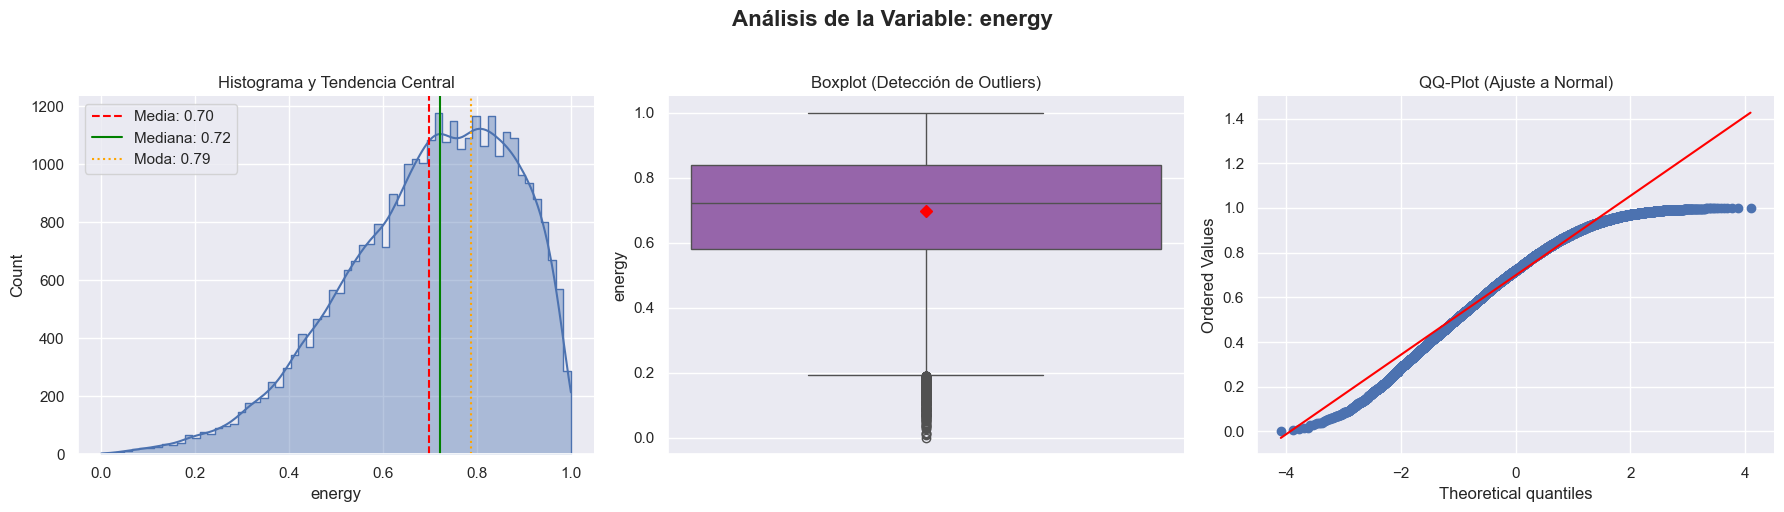

In [41]:
graficas.graficos_continuos(df, "energy")

In [42]:
graficas.guardar_grafico("distribucion energy")

El archivo 'distribucion energy.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [43]:
resumen_energy = resumen_numerico("energy", screen=False)

In [44]:
resumen_energy

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,energy,0.698619,0.721,0.18091,-0.63633,Sesgo negativo (izquierda),0.000528,mesocurtica,"[0.581, 0.84]",0.259,"[0.19, 1.23]",32833,False,1.356002e-87


In [45]:
saver.guardar_csv(resumen_energy, "resumen_energy.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_energy.csv
Operación cancelada para evitar duplicados.


Observando el histograma se identifica un claro sesgo a la izquierda. la variable **no** tiene comportamiento normal, respaldado tanto por la forma del histograma, el Q-Q plot y el test de Kolmogorov-smirnov cuyo p-valor fue despreciable, el boxplot permite evidenciar la presencia de un alto volumen de valores atipicos bajo el limite inferior del enfoque robusto de deteccion de outliers. <br><br>
El del $50\%$ de los datos es de $0.721$ de energy con una desviacion estandar considerable ($0.18091$).<br><br>
Por lo anterior se determina que el $50\%$ central de las canciones presentan una energia relativamente alta que se encuentra entre el intervalo [0.581, 0.84], es decir es muy comun encontrar canciones con dicha energia, y es poco comun hallar canciones con baja energia, lo cual indica una alta presencia de canciones relacionadas a generos energicos.

---



#### track_popularity (popularidad de la pista)

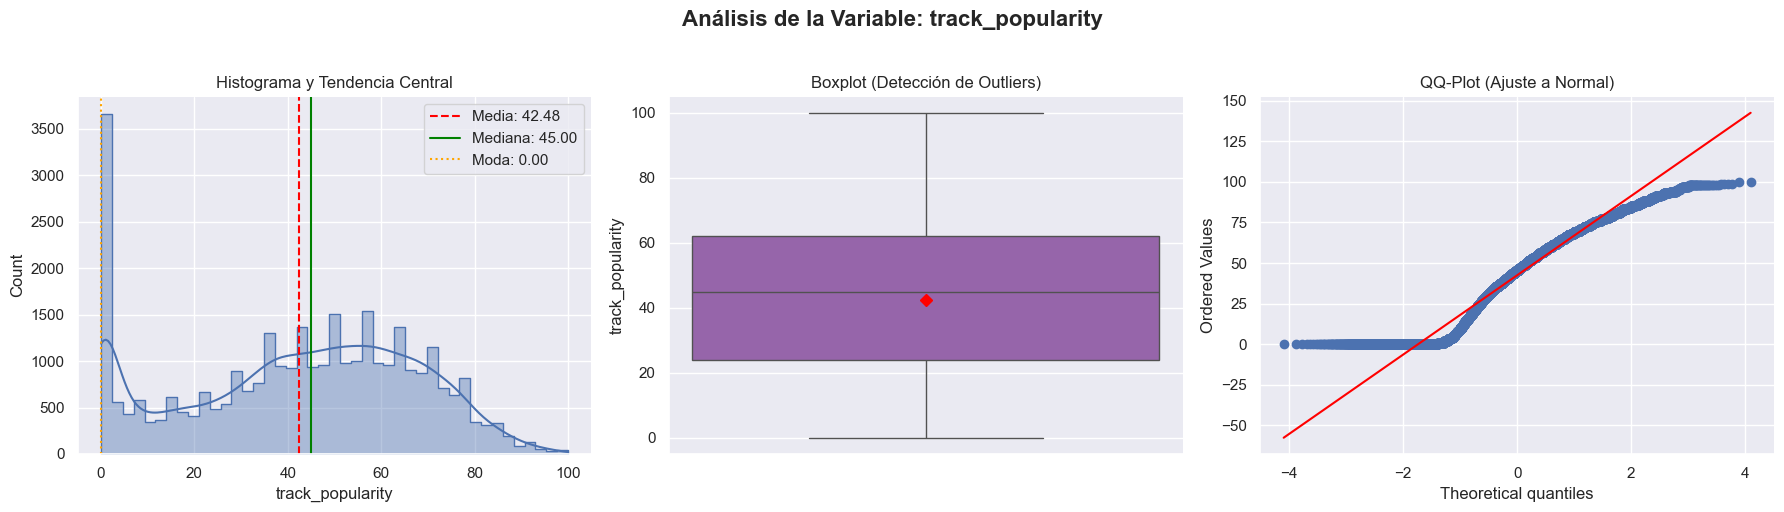

In [46]:
graficas.graficos_continuos(df, "track_popularity")

In [47]:
graficas.guardar_grafico("distribucion de la popularidad")

El archivo 'distribucion de la popularidad.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [48]:
resumen_popularity = resumen_numerico("track_popularity", screen=False)
resumen_popularity

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,track_popularity,42.477081,45.0,24.984074,-0.23332,Simétrica,-0.93277,platicurtica,"[24.0, 62.0]",38.0,"[-33.00, 119.00]",32833,False,3.931362e-140


In [49]:
saver.guardar_csv(resumen_popularity, "resumen_popularity.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_popularity.csv
Operación cancelada para evitar duplicados.


La variable es platicurtica, presenta una forma de campana en la mayoria de su dominio, el Q-Q plot y la prueba de normalidad indican que la variable no es normal, no se detectan outliers. 


Un fenomeno importante a mencionar es que hay un pico extremadamente alto en la distribucion en los valores que corresponden a popularidades cercanas a 0, A futuro sera interesante analizar que factores causan que una cancion fracase de tal manera, puede ser una gran opcion separar las canciones en 2 grupos segun su popularidad y analizar las canciones populares y las que fracasaron.

La popularidad que marca el centro de la distribucion es 45.0, el 50% central de la canciones estan entre [24.0, 62.0] y presenta una desviacion estandar considerable para la escala de los datos (24.98).

<small><b>Nota:</b> Si bien segun la interpretacion de la funcion los datos son simetricos, es importante destacar que probablemente el pico en 0 este alterando algunos estadisticos por lo que la media no es del todo confiable, si se eliminan o separan los valores correspondientes a ese pico si se podra confiar en la simetria general indicada por sk</small>

---

#### loudness (sonoridad general de una pista)

La sonoridad general de una pista en decibelios (dB). Los valores de sonoridad se promedian en toda la pista y son útiles para comparar la sonoridad relativa de las pistas. La sonoridad es el volumen percibido por el oído humano a lo largo del tiempo, independientemente de la potencia real de los altavoces. Los valores suelen oscilar entre -60 y 0 db. 

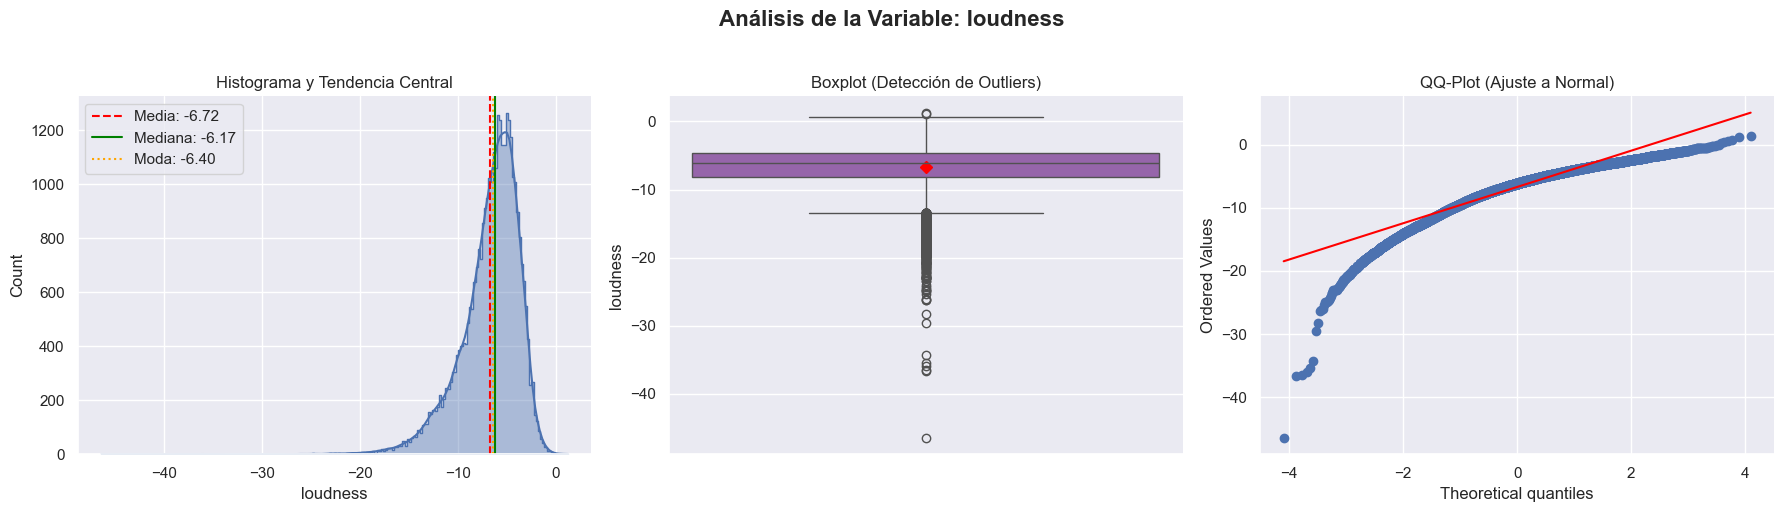

In [50]:
graficas.graficos_continuos(df, "loudness")

In [51]:
resumen_loudness = resumen_numerico("loudness", screen=False)
resumen_loudness

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,loudness,-6.719499,-6.166,2.988436,-1.364097,Sesgo negativo (izquierda),4.490958,leptocurtica,"[-8.171, -4.645]",3.526,"[-13.46, 0.64]",32833,False,1.279175e-203


In [52]:
saver.guardar_csv(resumen_loudness, 'resumen_loudness.csv')

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_loudness.csv
Operación cancelada para evitar duplicados.


Si bien el impacto de la variable en el objetivo del negocio puede ser discutible se procede a su analisis por la posibilidad de hallarle una correlacion interesante a futuro, claramente la variable no es normal (respaldado por las mismas razones expuestas en items anteriores), presenta un fuerte sesgo a la izquierda y ademas posee un alto numero de outliers bajo el limite inferior. El 50% de pistas tiene un loudness promedio entre [-8.171, -4.645].

---

#### speechiness 

La "speechiness" detecta la presencia de palabras habladas en una pista. Cuanto más exclusivamente parecida al habla sea la grabación (por ejemplo, un programa de entrevistas, un audiolibro, poesía), más cerca de 1.0 estará el valor del atributo. **Los valores superiores a 0.66 describen pistas que probablemente estén compuestas en su totalidad por palabras** habladas. Los valores entre 0.33 y 0.66 describen pistas que pueden contener tanto música como habla, ya sea en secciones o en capas, incluyendo casos como la música rap. Los valores inferiores a 0.33 representan probablemente música y otras pistas que no son de tipo habla. 

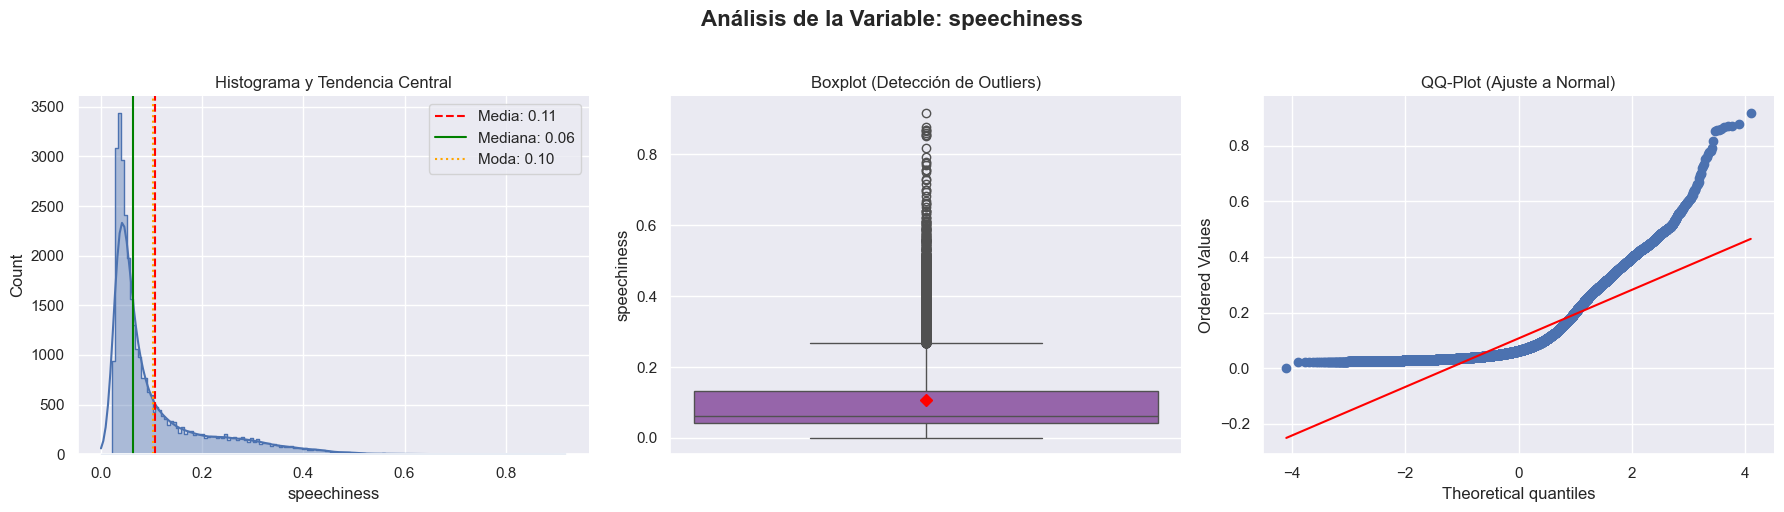

In [53]:
graficas.graficos_continuos(df, "speechiness")

In [54]:
graficas.guardar_grafico("distribucion speechiness 2")

El archivo 'distribucion speechiness 2.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [55]:
resumen_speechiness = resumen_numerico('speechiness', screen=False)
resumen_speechiness

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,speechiness,0.107068,0.0625,0.101314,1.967029,Sesgo positivo (derecha),4.260835,leptocurtica,"[0.041, 0.132]",0.091,"[-0.10, 0.27]",32833,False,0.0


In [56]:
saver.guardar_csv(resumen_speechiness, 'resumen_speechiness.csv')

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_speechiness.csv
Operación cancelada para evitar duplicados.


La variable presenta un fuerte sesgo a la derecha, una baja desviacion estandar, evidentemetne no es normal, tiene un alta presencia de outliers sobre el limite superior.
el 50% central de los valores se encuentran entre [0.041, 0.132] lon cual indica que el 50% de la muestra esta conformada con pistas con alta musicalidad, y la cola de la derecha indica lo poco comun que es en esta muestra productos como podcasts.<br><br>
Esto es ideal para el objetivo del negocio (el cual es musical), esta variable puede tener 2 usos principales a futuro el primero reconocer que indice de musicalidad genera mayor popularidad y ademas filtrar los contenidos que son hablados como podcasts.

#### acousticness

Una medida de confianza de 0.0 a 1.0 sobre si la pista es acústica. 1.0 representa una confianza alta de que la pista es acústica.

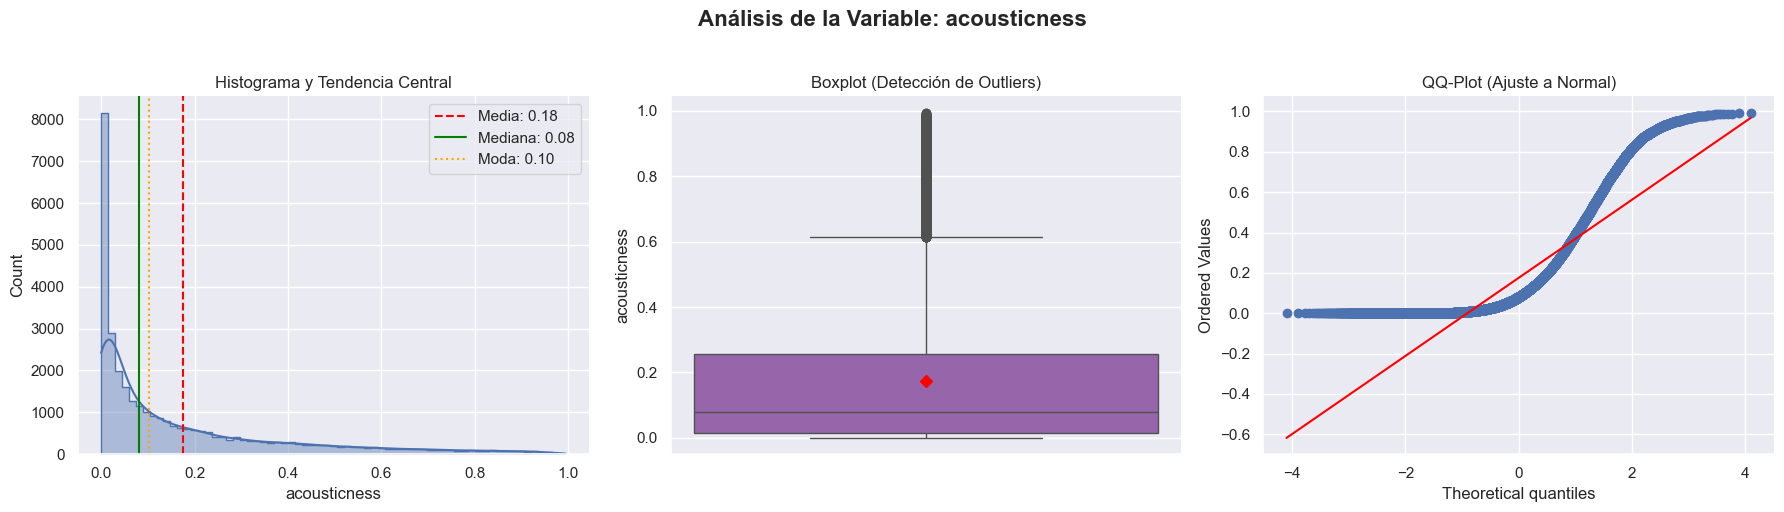

In [57]:
graficas.graficos_continuos(df, "acousticness")

In [58]:
graficas.guardar_grafico("acousticness")

El archivo 'acousticness.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [59]:
resumen_acousticness = resumen_numerico('acousticness', screen= False)
resumen_acousticness

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,acousticness,0.175334,0.0804,0.219633,1.594786,Sesgo positivo (derecha),1.878409,leptocurtica,"[0.0151, 0.255]",0.2399,"[-0.34, 0.61]",32833,False,0.0


In [60]:
saver.guardar_csv(resumen_acousticness, "resumen_acousticness.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_acousticness.csv
Operación cancelada para evitar duplicados.


La distribucion tiene sesgo a la derecha, alta presencia de atipicos sobre el limite superior, y evidentemente no es normal.

el 50% de las observaciones estan en el intervalo [0.0151, 0.255] es decir no se tiene gran confianza de si es acustica, por lo que probablemente no lo sea, en genral las canciones de las cual se tiene alta confianza de ser acusticas (>0.5) son pocas, lo cual puede ser un indicio de que las canciones puramente acusticas son mas extrañas, por lo que firmar artistas con canciones acusticas lo puede relegar a un nicho, esto se debera evaluar mas adelante.

<small><b>Nota:</b> no se le da total confianza a esta varaible precisamente por ser un indice de seguridad, sin embargo es un indicio valioso para el estudio.</small>

#### instrumentalness

Predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" se tratan como instrumentales en este contexto. Las pistas de rap o de palabras habladas son claramente "vocales". Cuanto más cercano a 1.0 sea el valor de instrumentalidad, mayor será la probabilidad de que la pista no contenga contenido vocal. **Los valores superiores a 0.5 están destinados a representar pistas instrumentales**, pero la confianza es mayor a medida que el valor se acerca a 1.0.

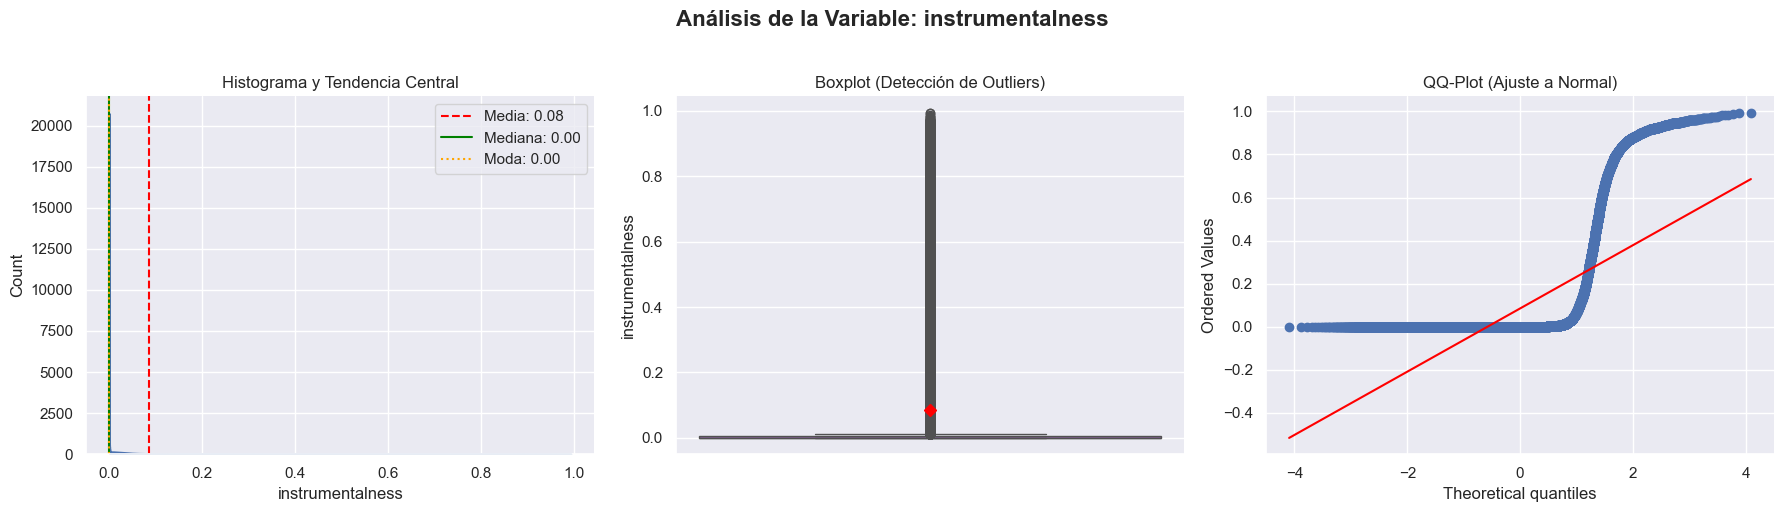

In [61]:
graficas.graficos_continuos(df, "instrumentalness")

In [62]:
graficas.guardar_grafico("instrumentalness_crazy")

El archivo 'instrumentalness_crazy.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [63]:
resumen_instrumentalness = resumen_numerico('instrumentalness', screen= False)
resumen_instrumentalness

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,instrumentalness,0.084747,0.000016,0.22423,2.759472,Sesgo positivo (derecha),6.274061,leptocurtica,"[0.0, 0.00483]",0.00483,"[-0.01, 0.01]",32833,False,0.0


In [64]:
saver.guardar_csv(resumen_instrumentalness, "resumen_instrumentalness.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_instrumentalness.csv
Operación cancelada para evitar duplicados.


Practicamente ninguna cancion es puramente instrumental, evidentemente no hay normalidad, y existe una gran masa de valores atipicos, aun asi pocos estan sobre el rango de ser puramente instrumentales (>0.5), la variable no da informacion altamente valiosa.

#### valence

Una medida de 0.0 a 1.0 que describe la positividad musical transmitida por una pista. Las pistas con una valencia alta suenan más positivas (por ejemplo, felices, alegres, eufóricas), mientras que las pistas con una valencia baja suenan más negativas (por ejemplo, tristes, deprimidas, enfadadas).

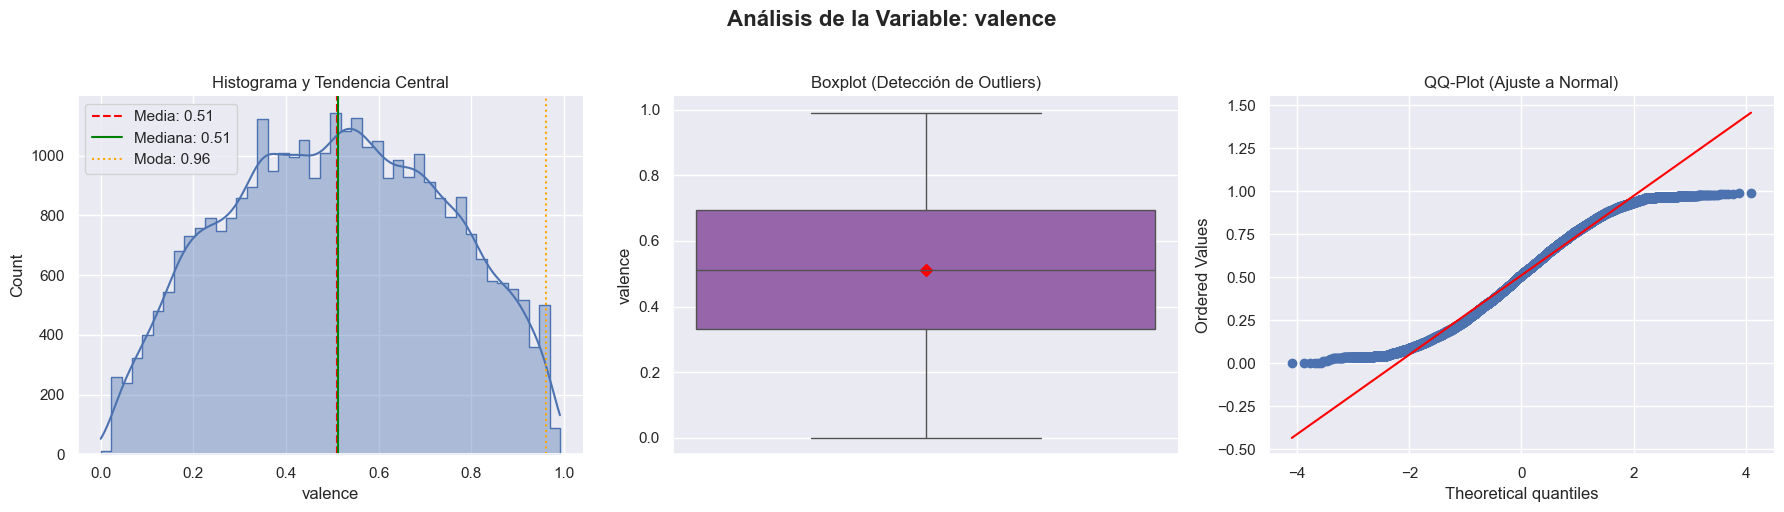

In [65]:
graficas.graficos_continuos(df, "valence")

In [66]:
graficas.guardar_grafico("distribucion de valence")

El archivo 'distribucion de valence.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [67]:
resumen_valence = resumen_numerico("valence", screen=False)
resumen_valence

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,valence,0.510561,0.512,0.233146,-0.005485,Simétrica,-0.900981,platicurtica,"[0.331, 0.693]",0.362,"[-0.21, 1.24]",32833,False,4.802329e-35


In [68]:
saver.guardar_csv(resumen_valence, "resumen_valence.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\resumen_valence.csv
Operación cancelada para evitar duplicados.


La variable es simetrica con una forma platicurtica, no es normal sin embargo una transformacion logaritmica podria transformarla a futuro, el valor medio de `valence` es de 0.510561, es decir un valor conservador (no se percibe como positiva pero tampoco especialmente negativa), ademas el 50% central esta entre [0.331, 0.693] lo cual complementa la sospecha de que las canciones o extremadamente negativas o extremadamente positivas son poco comunes, por lo que probablemente la estrategia adecuada no consista en crear canciones extremadamente positivas o negativas. No hay presencia de valores atipicos o algun problema de calidad claro.

#### tempo

El tempo general estimado de una pista en pulsaciones por minuto (BPM). En terminología musical, el tempo es la velocidad o el ritmo de una pieza determinada y se deriva directamente de la duración media de los compases.

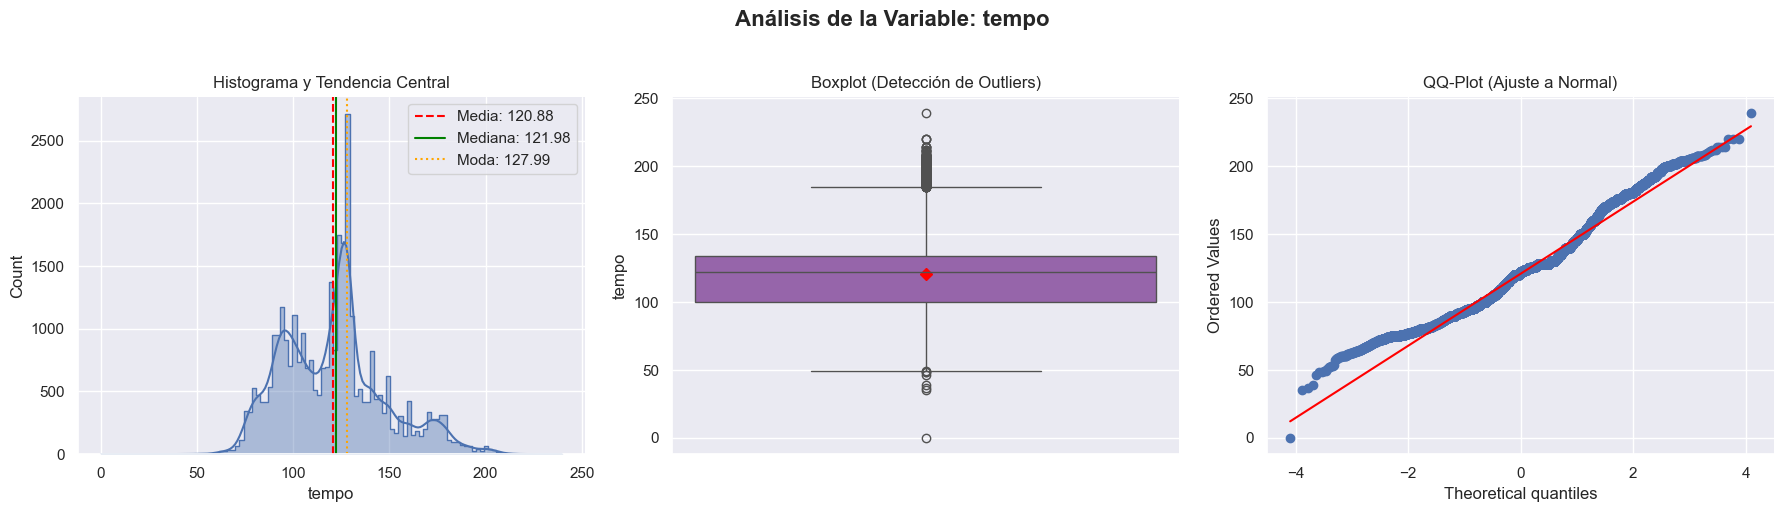

In [69]:
graficas.graficos_continuos(df, "tempo")

In [70]:
graficas.guardar_grafico("distribucion tempo")

El archivo 'distribucion tempo.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [71]:
resumen_tempo = resumen_numerico('tempo', screen=False)
resumen_tempo

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,tempo,120.881132,121.984,26.903624,0.528878,Sesgo positivo (derecha),0.083264,mesocurtica,"[99.96, 133.918]",33.958,"[49.02, 184.86]",32833,False,4.870543e-251


La distribucion presenta 2 picos importantes estos probablemente sean rangos de tempo usuales en la industria, el q-q plot trata de ajustarse a los cuantiles teoricos, sin embargo falla probablemente por la propiedad de los 2 picos asi como tambien falla el test de normalidad, se observa un ligero sesgo a la derecha. El valor medio de tempo es 120.88, la desviacion estandar es relativamente baja respecto a la escala de la variable y el 50% central esta entre [99.96, 133.918], por lo que dicho rango indica bpms optimos segun la industria. <br><br>
Se observan outliers tanto superiores como inferiores, representando canciones que curiosamente son muy lentas o rapidas.<br><br>
El comportamiento de la variable es peculiar sin embargo proporciona informacion de tempos usuales en la industria, lo cual puede dar un indicio de que tempo potenciara la popularidad de los artistas.

#### duration_ms

Duración de la canción en milisegundos, se transformara para hacerla mas facil de interpretar

In [72]:
df['duration_min'] = df['duration_ms']/60000

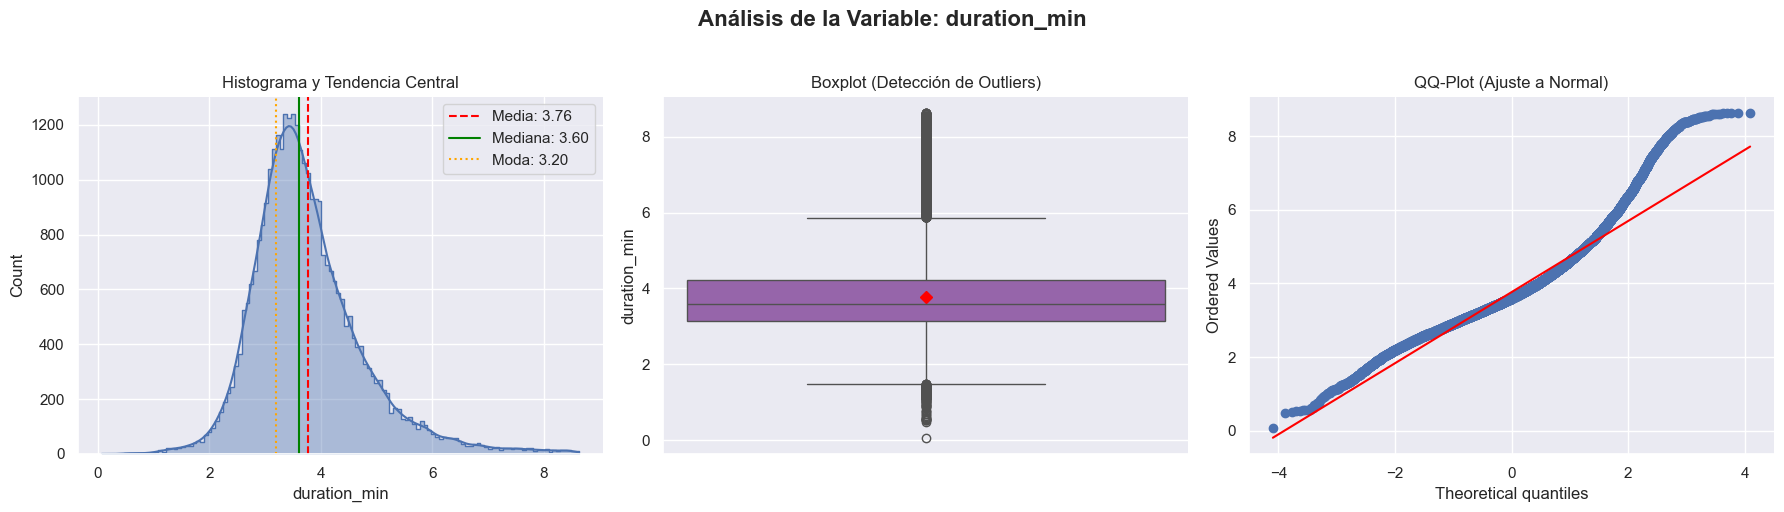

In [73]:
graficas.graficos_continuos(df, "duration_min")

In [74]:
graficas.guardar_grafico("duration_min distribucion")

El archivo 'duration_min distribucion.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [75]:
resumen_duration_min =  resumen_numerico('duration_min', screen=False)
resumen_duration_min

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,duration_min,3.76333,3.6,0.997233,1.149863,Sesgo positivo (derecha),2.699186,leptocurtica,"[3.130316666666667, 4.226416666666666]",1.0961,"[1.49, 5.87]",32833,False,4.869622e-211


La variable tiene un sesgo a la derecha, la duracion mediana de las canciones es de 3.60 minutos y la duracion promedio de 3.76 minutos, el 50% central esta entre [3.13, 4.226] lo cual indica que probablemente este rango es ideal para asegurar la rotación en radio y la retención del oyente en plataformas de streaming, subcecuentemente potenciando la popularidad. <br><br>

A pesar de presentar una forma de campana no se comporta normal principalmente por el sesgo y su elevada curtosis, sin embargo es posible considerar un ajuste de una distribucion $\chi^2$ para calcular probabilidades de duracion de las canciones. Esta serie de valores indica que en la industria el estandar son canciones de baja duracion. A pesar de la precencia tanto canciones muy cortas o muy largas (outliers) en la distribucion, lo mejor para asegurar el exito de una cancion es ajustarse a estas duraciones comunes en el mercado, que como plus suelen variar muy poco ($S=0.997233$), lo cual da poco margen para errar a la duracion optima.

#### Crear tabla resumen

In [76]:
resumenes = [resumen_duration_min, resumen_tempo, resumen_valence, resumen_instrumentalness, resumen_acousticness, resumen_speechiness, resumen_loudness, resumen_popularity, resumen_energy, resumen_danceability]
df_resumen = pd.concat(resumenes, ignore_index=True)

In [77]:
df_resumen

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,duration_min,3.763330,3.600000,0.997233,1.149863,Sesgo positivo (derecha),2.699186,leptocurtica,"[3.130316666666667, 4.226416666666666]",1.09610,"[1.49, 5.87]",32833,False,4.869622e-211
1,tempo,120.881132,121.984000,26.903624,0.528878,Sesgo positivo (derecha),0.083264,mesocurtica,"[99.96, 133.918]",33.95800,"[49.02, 184.86]",32833,False,4.870543e-251
2,valence,0.510561,0.512000,0.233146,-0.005485,Simétrica,-0.900981,platicurtica,"[0.331, 0.693]",0.36200,"[-0.21, 1.24]",32833,False,4.802329e-35
3,instrumentalness,0.084747,0.000016,0.224230,2.759472,Sesgo positivo (derecha),6.274061,leptocurtica,"[0.0, 0.00483]",0.00483,"[-0.01, 0.01]",32833,False,0.000000e+00
4,acousticness,0.175334,0.080400,0.219633,1.594786,Sesgo positivo (derecha),1.878409,leptocurtica,"[0.0151, 0.255]",0.23990,"[-0.34, 0.61]",32833,False,0.000000e+00
5,speechiness,0.107068,0.062500,0.101314,1.967029,Sesgo positivo (derecha),4.260835,leptocurtica,"[0.041, 0.132]",0.09100,"[-0.10, 0.27]",32833,False,0.000000e+00
6,loudness,-6.719499,-6.166000,2.988436,-1.364097,Sesgo negativo (izquierda),4.490958,leptocurtica,"[-8.171, -4.645]",3.52600,"[-13.46, 0.64]",32833,False,1.279175e-203
7,track_popularity,42.477081,45.000000,24.984074,-0.233320,Simétrica,-0.932770,platicurtica,"[24.0, 62.0]",38.00000,"[-33.00, 119.00]",32833,False,3.931362e-140
8,energy,0.698619,0.721000,0.180910,-0.636330,Sesgo negativo (izquierda),0.000528,mesocurtica,"[0.581, 0.84]",0.25900,"[0.19, 1.23]",32833,False,1.356002e-87
9,danceability,0.654850,0.672000,0.145085,-0.504488,Sesgo negativo (izquierda),0.010202,mesocurtica,"[0.563, 0.761]",0.19800,"[0.27, 1.06]",32833,False,1.042808e-64


In [78]:
saver.guardar_csv(df_resumen, "df_resumen_numerico.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\df_resumen_numerico.csv
Operación cancelada para evitar duplicados.


## 3.2 Analisis Bivariado

### 3.2.1 Relacion entre variables numericas

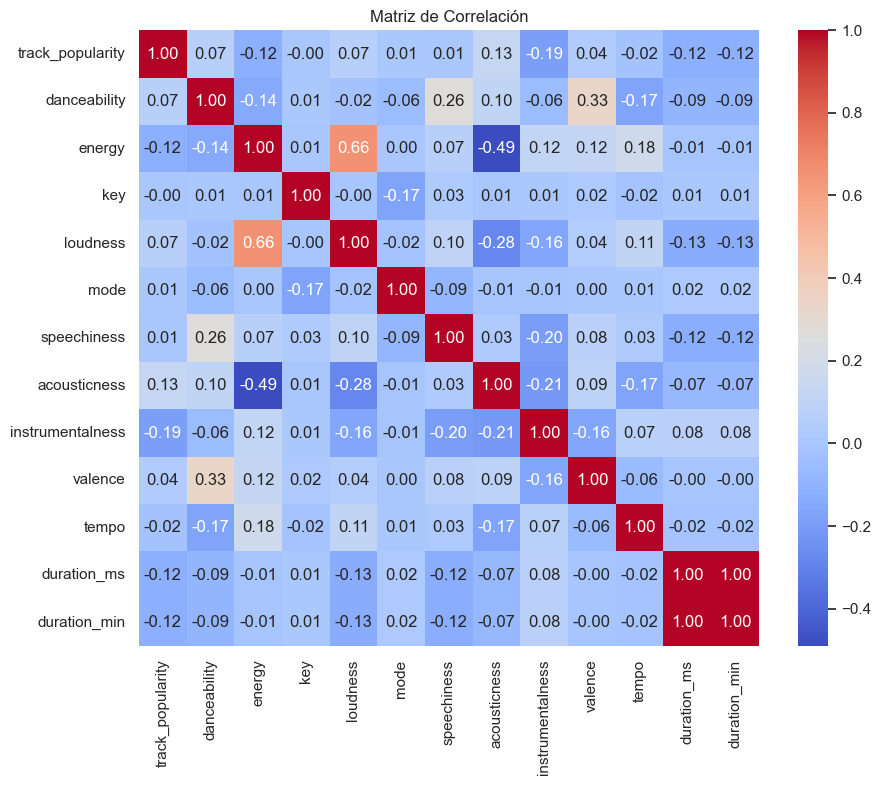

In [79]:
matriz_corr = df.corr(numeric_only=True, method='spearman') #usar spearman para considerar relaciones sin verse afectado por la falta de normalidad

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Se aprecia que las unicas relaciones claras que hay son:

* loudness vs energy
* acousticness vs energy
* valence vs danceability (debil, pero mejor que el resto)

por lo que a continuacion se hara especial enfasis en estas, para reconocer de mejor manera su naturaleza y posible impacto en el negocio, ademas es importante destacar que no hay una variable que tenga una realcion especialmente fuerte con la popularidad, es probable que para determinar esta se requiera utilizar varias variables.

<small><b>Nota:</b> no se toma en cuenta entre duration_ms y duration_min ya que basicamente son la misma variable</small>

#### loudness vs energy

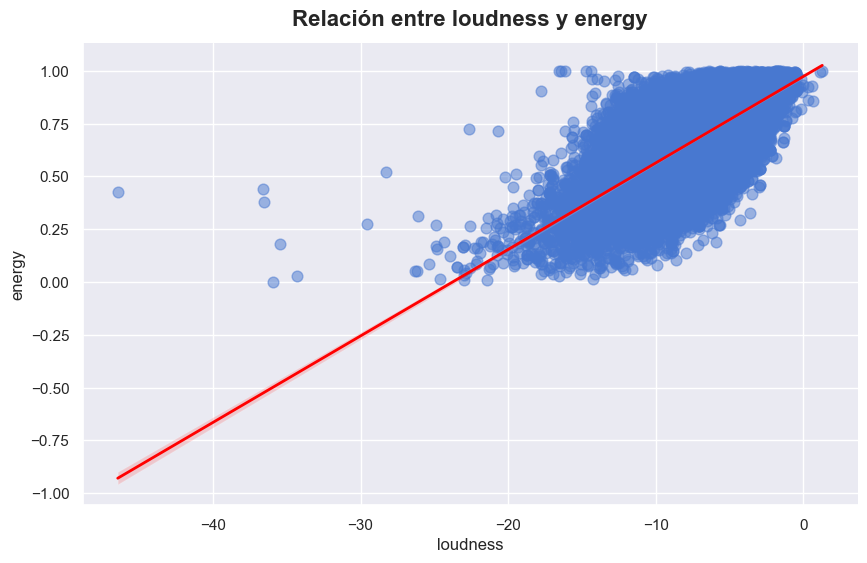

In [80]:
graficas.scatter_plot(df, 'loudness', 'energy')

In [81]:
graficas.guardar_grafico("relacion de loudness y energy")

El archivo 'relacion de loudness y energy.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


In [82]:
rho, p_s = stats.spearmanr(df['loudness'], df['energy'])
print(rho, p_s)

0.6561312555671224 0.0


In [83]:
tau, p_k = stats.kendalltau(df['loudness'], df['energy'])
print(tau, p_k)

0.4744443050139469 0.0


In [84]:
print(f"p valor spearman: {p_s}\np valor kendall: {p_k}")

p valor spearman: 0.0
p valor kendall: 0.0


El grafico permite observar que hay una relacion fuerte entre las variables (con algunos outliers tanto multivariados como univariados), sospecha que se refuerza por kendall ($0.474$) y spearman ($0.656$) cuyos valores son significativos, ademas en ambos casos se descarto la hipotesis nula, por lo que se logro recabar suficiente informacion para determinar su relacion.

Esto se traduce en que mientras mas "ruidosas" son las canciones tienden a transimitir una sensacion de mayor energia, esto por la magnitud de spearman se puede decir que este efecto tiene una fuerza media-alta.


#### acousticness vs energy

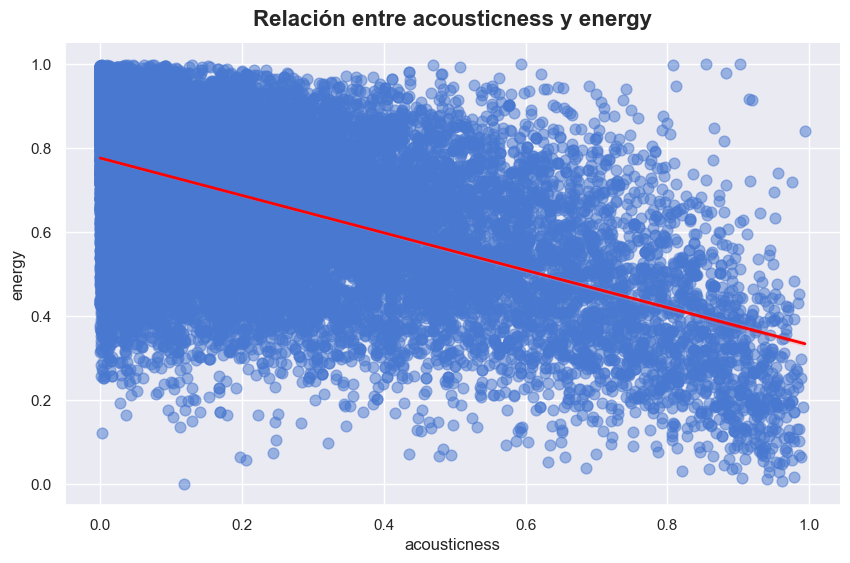

In [85]:
graficas.scatter_plot(df, 'acousticness', 'energy')

In [86]:
rho, p_s = stats.spearmanr(df['acousticness'], df['energy'])
print(rho, p_s)

-0.49117667041218677 0.0


In [87]:
tau, p_k = stats.kendalltau(df['acousticness'], df['energy'])
print(tau, p_k)

-0.3447686557439833 0.0


Si bien los valores de correlacion tanto de kendall ($-0.344$) como de spearman ($-0.491$) indican cierta correlacion entre variables, graficamente luce como una nube con una clara pendiente negativa, pero con un cumulo en el cuadrante superior izquierdo, sin embargo esta relacion aunque debil puede ser util a futuro. En general indica de una manera vaga que mientras una cancion tenga mas probabilidad de ser acustica su energia ira en declibe, lo cual puede insinuar que las canciones acusticas tienden a ser mas tranquilas y apacibles.<br><br>
Esto permite a la disquera segmentar su catálogo; si se busca impacto en listas de éxitos "enérgicas", se debera evitar altos niveles de acousticness.

#### valence vs danceability

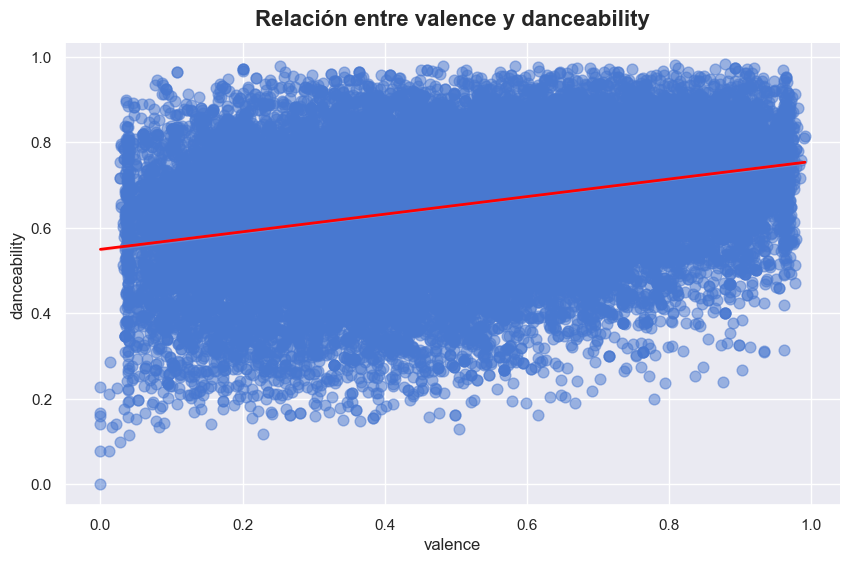

In [88]:
graficas.scatter_plot(df, 'valence', 'danceability')

In [89]:
rho, p_s = stats.spearmanr(df['valence'], df['danceability'])
print(rho, p_s)

0.3307413407933803 0.0


Se observa una nube de datos con una ligera pendiente positiva, ademas el coeficiente de spearman ($0.3307$) indica que existe una relacion debil entre las variables, en general indica que las canciones que tienen una "vibra" positiva tienden a ser vas bailables, por lo que si la disquera desea que sus artistas se frecuenten en discotecas deberan incrementar el valance de sus canciones para ser ligeramente mas bailables.

### 3.2.2 Asociacion Categorica

En esta seccion se tratara de establecer relacion entre las categorias que hay.

#### Estudio artistas populares vs no populares

Por el alto volumen de artistas que hay se van a clasificar como populares y no populares seegun su popularidad media

In [90]:
########## en lugar de buscar los top 10 artistas clacificar en popular y no popular

pop_promedio = df.groupby("track_artist")['track_popularity'].mean().sort_values().to_dict()
df['popular'] = df['track_artist'].map(pop_promedio)
df['popular'] = df['popular'].apply(lambda x: "popular" if x > 50 else "no popular")

In [91]:
df['popular'].value_counts()

popular
no popular    20905
popular       11928
Name: count, dtype: int64

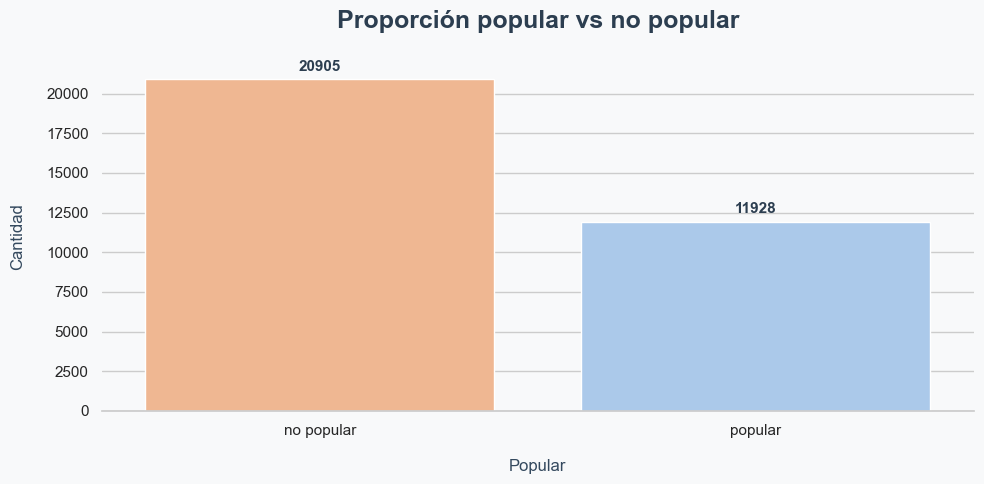

In [92]:
graficas.barplot_discreto(df, 'popular', titulo="Proporción popular vs no popular", etiqueta_x="Popular")

In [93]:
graficas.guardar_grafico('Proporción popular vs no popular')

El archivo 'Proporción popular vs no popular.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


vea que la gran mayoria de artistas no son populares, a continuacion se vera si hay alguna relacion entre ser popular con el genero.

In [94]:
tabla_obs = pd.crosstab(df['popular'], df['playlist_genre'])
tabla_obs

playlist_genre,edm,latin,pop,r&b,rap,rock
popular,,,,,,
no popular,4740,2804,2935,3574,3575,3277
popular,1303,2351,2572,1857,2171,1674


In [95]:
chi2, p, dof, esperadas = stats.chi2_contingency(tabla_obs)

In [96]:
print("="*40)
print("     DETALLE DEL TEST CHI-CUADRADO")
print("="*40)
print(f"Estadístico (Chi2): {chi2:.4f}")
print(f"P-valor:           {p:.4e}")
print(f"Grados de Libertad: {dof}")
print("-"*40)
print("Frecuencias Esperadas (Teóricas):")
# Convertimos a DataFrame para que se vea bonito con etiquetas
df_esperadas = pd.DataFrame(esperadas,
                            index=tabla_obs.index,
                            columns=tabla_obs.columns)
df_esperadas

     DETALLE DEL TEST CHI-CUADRADO
Estadístico (Chi2): 1047.3013
P-valor:           3.4482e-224
Grados de Libertad: 5
----------------------------------------
Frecuencias Esperadas (Teóricas):


playlist_genre,edm,latin,pop,r&b,rap,rock
popular,,,,,,
no popular,3847.62023,3282.224439,3506.345293,3457.955563,3658.518259,3152.336217
popular,2195.37977,1872.775561,2000.654707,1973.044437,2087.481741,1798.663783


In [97]:
saver.guardar_csv(pd.DataFrame(esperadas), "esperadas_artista_genero.csv", indexx=True)

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\esperadas_artista_genero.csv
Operación cancelada para evitar duplicados.


In [98]:
def v_cramer(tabla, chi2_val):
    n = tabla.sum().sum()
    r, k = tabla.shape
    return np.sqrt((chi2_val / n) / min(k - 1, r - 1))

v = v_cramer(tabla_obs, chi2)
v

np.float64(0.17859961918968162)

Si bien el p-valor de la prueba $\chi^2$ indica que hay una relacion entre las 2 variables categoricas, la v de crammer indica que la relacion entre dichas variables es debil $V=0.178$ lo cual indica que la relacion que se establece entre las 2 no es altamente significativa, sin embargo si existe cierta relacion entre un artista popular y los generos que canta.

#### Estudio a la popularidad de las canciones y su genero (se considera que hay canciones que aparecen en varias playlists).

In [99]:
df['popularidad cancion'] = df['track_popularity'].apply(lambda x: "popular" if x > 50 else "no popular")

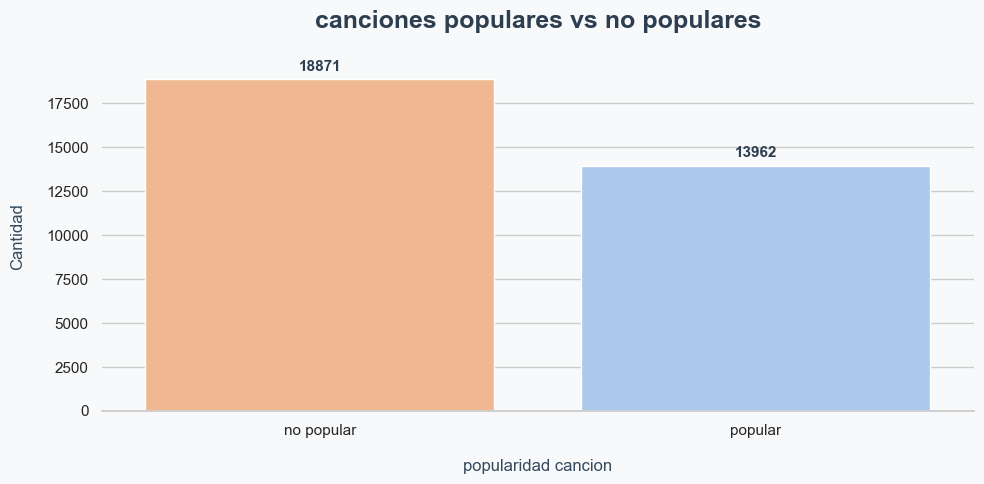

In [100]:
graficas.barplot_discreto(df, 'popularidad cancion', titulo="canciones populares vs no populares", etiqueta_x="popularidad cancion")

In [101]:
graficas.guardar_grafico("canciones populares vs no populares")

El archivo 'canciones populares vs no populares.png' ya existe en 'd:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos'.
Usa 'sobrescribir=True' si deseas reemplazarlo.


La mayoria de cancione no son populares.

In [102]:
tabla_obs = pd.crosstab(df['popularidad cancion'], df['playlist_genre'])
tabla_obs

playlist_genre,edm,latin,pop,r&b,rap,rock
popularidad cancion,,,,,,
no popular,4498,2603,2631,3184,3219,2736
popular,1545,2552,2876,2247,2527,2215


In [103]:
chi2, p, dof, esperadas = stats.chi2_contingency(tabla_obs)
print("="*40)
print("     DETALLE DEL TEST CHI-CUADRADO")
print("="*40)
print(f"Estadístico (Chi2): {chi2:.4f}")
print(f"P-valor:           {p:.4e}")
print(f"Grados de Libertad: {dof}")
print("-"*40)
print("Frecuencias Esperadas (Teóricas):")
# Convertimos a DataFrame para que se vea bonito con etiquetas
df_esperadas = pd.DataFrame(esperadas,
                            index=tabla_obs.index,
                            columns=tabla_obs.columns)
df_esperadas

     DETALLE DEL TEST CHI-CUADRADO
Estadístico (Chi2): 1043.6181
P-valor:           2.1632e-223
Grados de Libertad: 5
----------------------------------------
Frecuencias Esperadas (Teóricas):


playlist_genre,edm,latin,pop,r&b,rap,rock
popularidad cancion,,,,,,
no popular,3473.25718,2962.872872,3165.187372,3121.505833,3302.55432,2845.622423
popular,2569.74282,2192.127128,2341.812628,2309.494167,2443.44568,2105.377577


In [104]:
def v_cramer(tabla, chi2_val):
    n = tabla.sum().sum()
    r, k = tabla.shape
    return np.sqrt((chi2_val / n) / min(k - 1, r - 1))

v = v_cramer(tabla_obs, chi2)
v

np.float64(0.17828529089756523)

De nuevo el p-valor de la prueba $\chi^2$ indica que hay una relacion entre las 2 variables categoricas, la v de crammer indica que la relacion entre dichas variables es debil $V=0.178$ lo cual indica que la relacion que se establece entre las 2 no es altamente significativa, sin embargo si existe cierta relacion entre si una cancion el popular o no y su genero.

### Relacion numerica vs categorica

In [105]:
variables_numericas = ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_min']

#### popularidad cancion vs energy

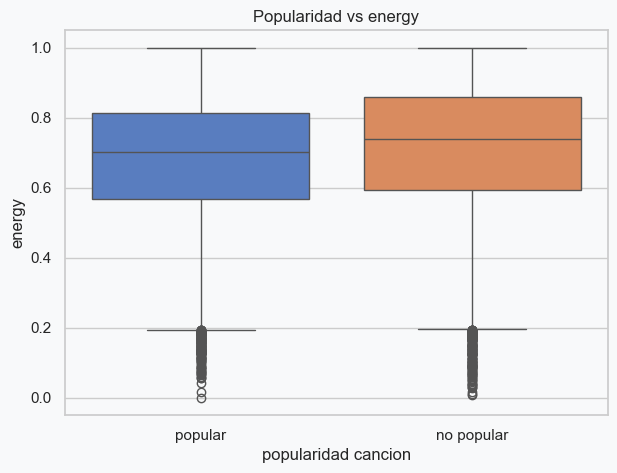

In [106]:

plt.figure(figsize=(7, 5))
sns.boxplot(x='popularidad cancion', y='energy', data=df, palette='muted', hue = 'popularidad cancion')
plt.title(f"Popularidad vs energy")
plt.show()

In [107]:
populares = df[df['popularidad cancion'] == 'popular']['energy']
no_populares = df[df['popularidad cancion'] == 'no popular']['energy']

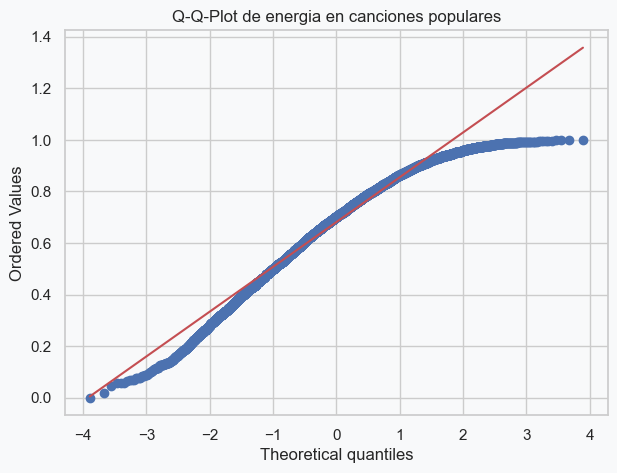

In [108]:
plt.figure(figsize=(7, 5))
stats.probplot(populares, dist="norm", plot=plt)
plt.title("Q-Q-Plot de energia en canciones populares")
plt.show()

Una de las distribuciones no es normal, por lo que se procede a aplicar el test U de mann-whitney

In [109]:
u_stat, p_valor = stats.mannwhitneyu(populares, no_populares)

print(f"\n--- RESULTADO MANN-WHITNEY U ---")
print(f"Estadístico U: {u_stat:.4f}")
print(f"P-valor:       {p_valor}")


--- RESULTADO MANN-WHITNEY U ---
Estadístico U: 117257098.0000
P-valor:       3.1753896667125553e-65


In [110]:
dct_resultados_popularidad_vs_energy = {"Estadístico U": [117257098.0000],
                                        "P-valor":[3.1753896667125553e-65]}

dct_resultados_popularidad_vs_energy_df = pd.DataFrame(dct_resultados_popularidad_vs_energy)
dct_resultados_popularidad_vs_energy_df

,Estadístico U,P-valor
0,117257098.0,3.175390e-65


In [111]:
saver.guardar_csv(dct_resultados_popularidad_vs_energy_df, "dct_resultados_popularidad_vs_energy_df.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\dct_resultados_popularidad_vs_energy_df.csv
Operación cancelada para evitar duplicados.


El p-valor de U (3.1753896667125553e-65), indica que efectivamete una distribución esta desplazada respecto a la otra, es decir hay dependencia o relacion entre la variable energy y popularidad cancion. <br><br>

Por lo general las canciones populares (indice de popularidad > 50) suelene tener una energia ligeramente mas baja que las no populares, por lo tanto es preferible que la canción no se perciba como excesivamente ruidosa o extrema, buscando un equilibrio en la producción, para llegar a un estilo ni muy lento o aburrido pero tampoco extremadamente ruidoso.

**Esto sugiere que el éxito comercial prefiere un equilibrio sonoro sin llegar a extremos ruidosos.**

#### Popularidad vs acousticness

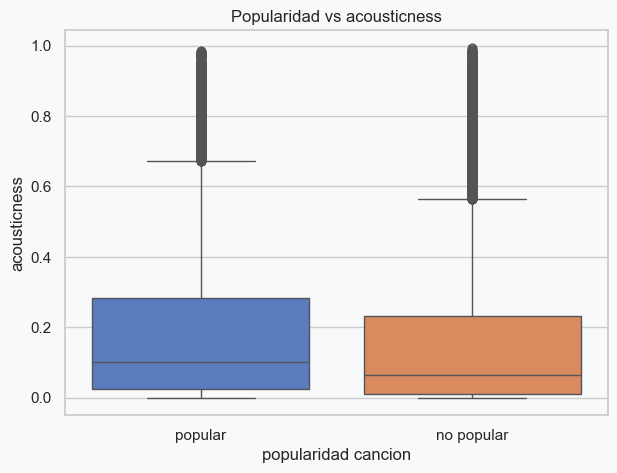

In [112]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='popularidad cancion', y='acousticness', data=df, palette='muted', hue = 'popularidad cancion')
plt.title(f"Popularidad vs acousticness")
plt.show()

In [113]:
populares = df[df['popularidad cancion'] == 'popular']['acousticness']
no_populares = df[df['popularidad cancion'] == 'no popular']['acousticness']

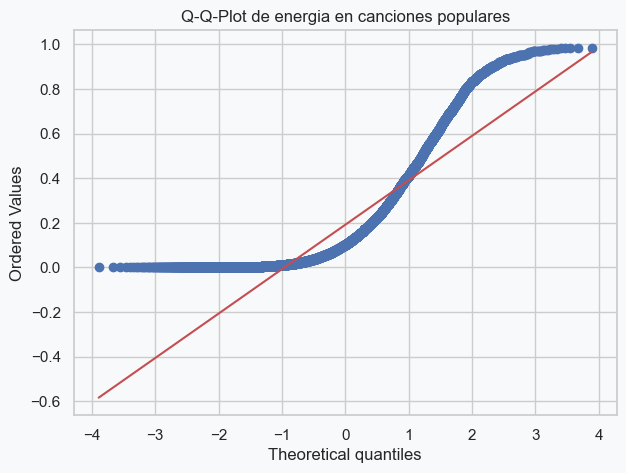

In [114]:
plt.figure(figsize=(7, 5))
stats.probplot(populares, dist="norm", plot=plt)
plt.title("Q-Q-Plot de energia en canciones populares")
plt.show()

Dada la falta de normalidad, se procede a usar U

In [115]:
u_stat, p_valor = stats.mannwhitneyu(populares, no_populares)

print(f"\n--- RESULTADO MANN-WHITNEY U ---")
print(f"Estadístico U: {u_stat:.4f}")
print(f"P-valor:       {p_valor}")


--- RESULTADO MANN-WHITNEY U ---
Estadístico U: 147558818.0000
P-valor:       1.7472693859124727e-77


In [116]:
dct_resultados_popularidad_vs_acousticness = {"Estadístico U": [u_stat],
                                        "P-valor":[p_valor]}

dct_resultados_popularidad_vs_acousticness_df = pd.DataFrame(dct_resultados_popularidad_vs_acousticness)
dct_resultados_popularidad_vs_acousticness_df

,Estadístico U,P-valor
0,147558818.0,1.747269e-77


In [117]:
saver.guardar_csv(dct_resultados_popularidad_vs_acousticness_df, "dct_resultados_popularidad_vs_acousticness_df.csv")

El archivo ya existe en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\tablas\dct_resultados_popularidad_vs_acousticness_df.csv
Operación cancelada para evitar duplicados.


El p-valor de U (1.7472693859124727e-77), indica que efectivamete una distribución esta desplazada respecto a la otra, es decir hay dependencia o relacion entre la variable acousticness y popularidad cancion. <br>

Por lo general las canciones populares (indice de popularidad > 50) suelen ser ligeramente mas acusticas que las no populares, aunque en este caso la diferencia no es tan marcada, ni significatiba pues el 50% central de ninguno de los 2 grupos sobrepasa el umbral de confianza para ser acusticas, solo es correcto decir que un ligero toque acustico pueda lograr que la cancion sea ligeramente mas popular.

**Las canciones populares tienden a ser ligeramente más acústicas que las no populares.**

## 3.3 Deteccion de outliers

In [120]:
def calcular_porcentaje_atipicos(data:pd.DataFrame ,var: str, screen=True):

    q1 = data[var].quantile(0.25)
    q3 = data[var].quantile(0.75)
    iqr = q3 - q1

    
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    
    outliers_mask = (data[var] < limite_inferior) | (data[var] > limite_superior)

    
    porcentaje_outliers = outliers_mask.mean() * 100 # .mean() sobre booleanos da la proporción (0 a 1)

    if screen:
        print(f"--- Análisis de: {var} ---")
        print(f"Límite Inferior: {limite_inferior:.4f}")
        print(f"Límite Superior: {limite_superior:.4f}")
        print(f"Porcentaje de atípicos: {porcentaje_outliers:.2f}%")
        print("-" * 30)
    return porcentaje_outliers

### 3.3.1 Outliers univariados

Si bien en el primer analisis ya se identificaron las variables con valores nulos en esta seccion se ahondara en esto, por ejemplo se analizara que proporcion de valores atipicos existe en cada una.

#### danceability

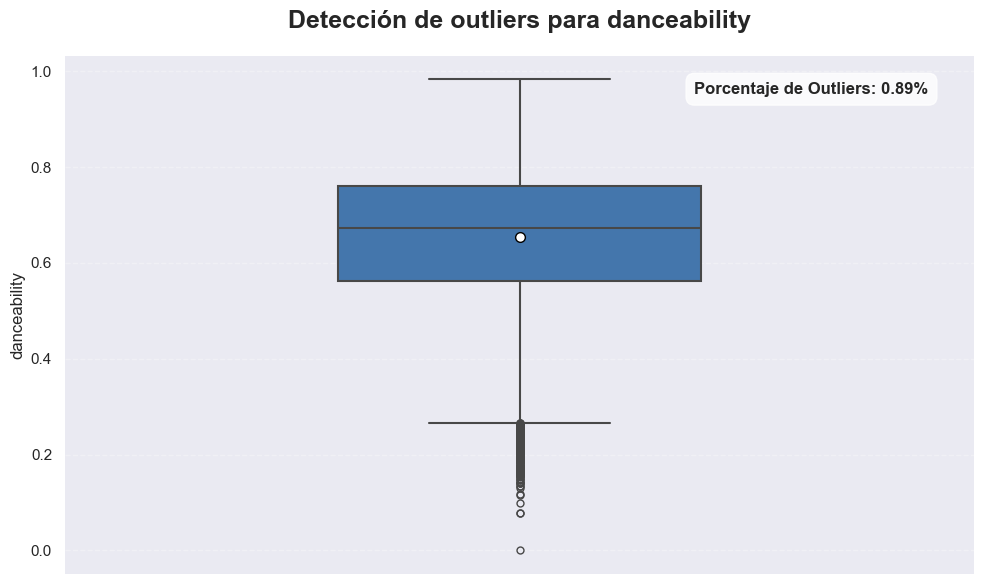

In [118]:
graficas.box_plot_para_atipicos(df, 'danceability')

In [121]:
graficas.guardar_grafico("outliers en danceability")

Gráfico guardado exitosamente en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos\outliers en danceability.png


In [119]:
resumen_danceability

,variable,media,mediana,std,asimetria,sesgo,curtosis,forma curtosis,intervalo central,iqr,no atipicos (iqr),largo,normalidad,p_valor
0,danceability,0.65485,0.672,0.145085,-0.504488,Sesgo negativo (izquierda),0.010202,mesocurtica,"[0.563, 0.761]",0.198,"[0.27, 1.06]",32833,False,1.042808e-64


Si bien a primera vista la cantidad de valores atipicos luce alarmante, si se calcula el procentaje de valores atipicos existentes en la muestra es de tan solo el 0.89%, una cantidad despreciable, por lo que se considera mantenerlos con el fin de no perder informacion.

#### energy

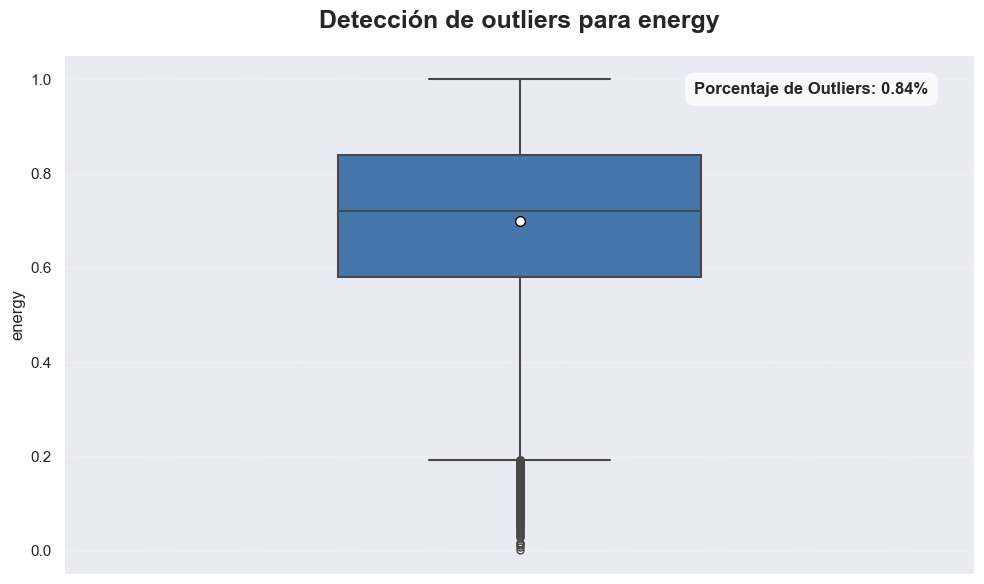

In [122]:
graficas.box_plot_para_atipicos(df, 'energy')

In [123]:
graficas.guardar_grafico("outliers en energy")

Gráfico guardado exitosamente en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos\outliers en energy.png


De nuevo el procentaje de atipicos presentes en la muestra es despreciable (0.84%) por lo que al ser valores generados de manera natural, ya que presenta cancions de energia baja se plantea dejarlos para representar dichos fenomenos.

#### loudness (sonoridad general de una pista)

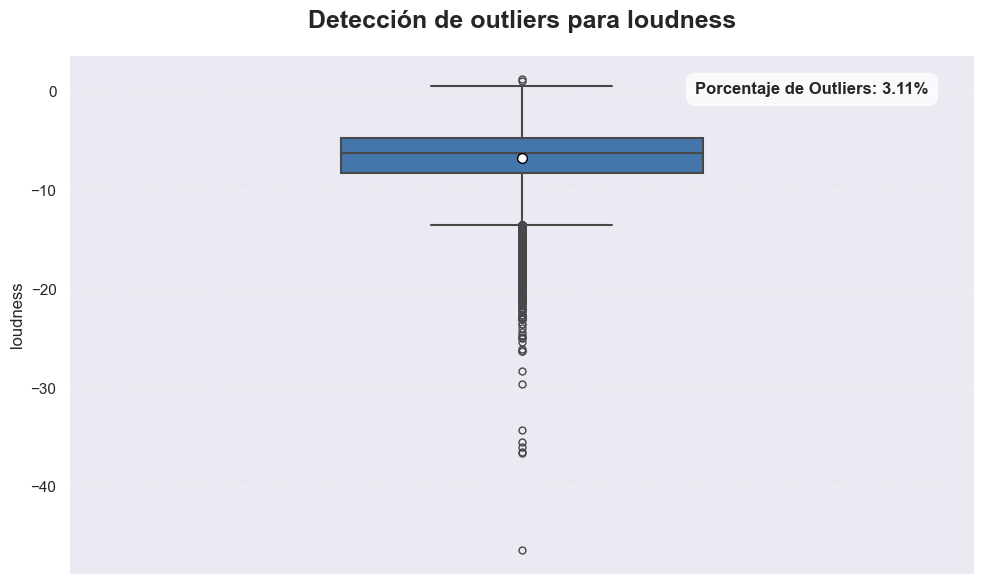

In [125]:
graficas.box_plot_para_atipicos(df, 'loudness')

In [126]:
graficas.guardar_grafico("outliers en loudness")

Gráfico guardado exitosamente en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos\outliers en loudness.png


En este caso existe un problema ligeramente mas marcado con los valores atipicos, si bien la cantidad continua siendo lo suficientemente pequeña para no ser alarmante, hay que destacar que aunque el 50% central de las observaciones estan muy concentradas en un rango pequeño, por lo que probablemente las grabaciones que se consideran outliers sean pistas con errores en produccion. A futuro se puede considerar la eliminacion de estos sujetos o analizar si los errores en produccion repercuten en la popularidad.

#### speechiness

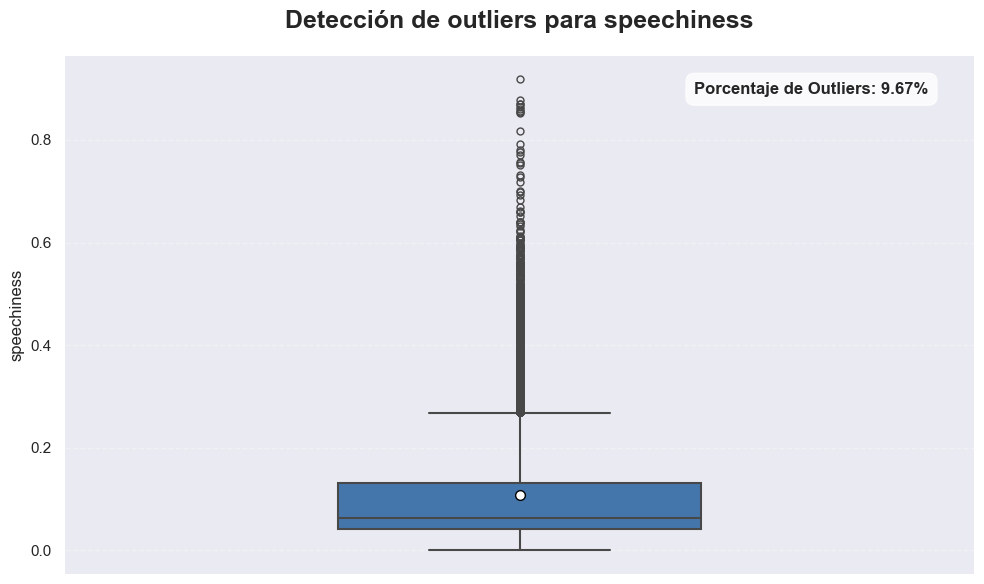

In [127]:
graficas.box_plot_para_atipicos(df, 'speechiness')

In [128]:
graficas.guardar_grafico("outliers en speechiness")

Gráfico guardado exitosamente en: d:\Externado\tercer semestre\Data Mining\Proyecto_Data_Mining_UEC\outputs\graficos\outliers en speechiness.png


En este caso el problema de los outliers es mucho mas marcado que en los casos anteriores, hay que recordar que las pistas con speechiness > 0.6 representan contenidos como podcasts, interludios hablados etc. Por la naturaleza musical del estudio se deberian eliminar registros sobre dicho limite; el resto de valores atipicos por debajo de dicho umbral pueden representar canciones de generos altamente hablados como rap o hip-hop, por lo que es valioso conservar dicha información.

<small><b>Nota:</b> Este cuaderno no abarca la limpieza, sin embargo a futuro se aplicara esta estrategia y se evaluara su impacto sobre los datos</small>

#### acousticness

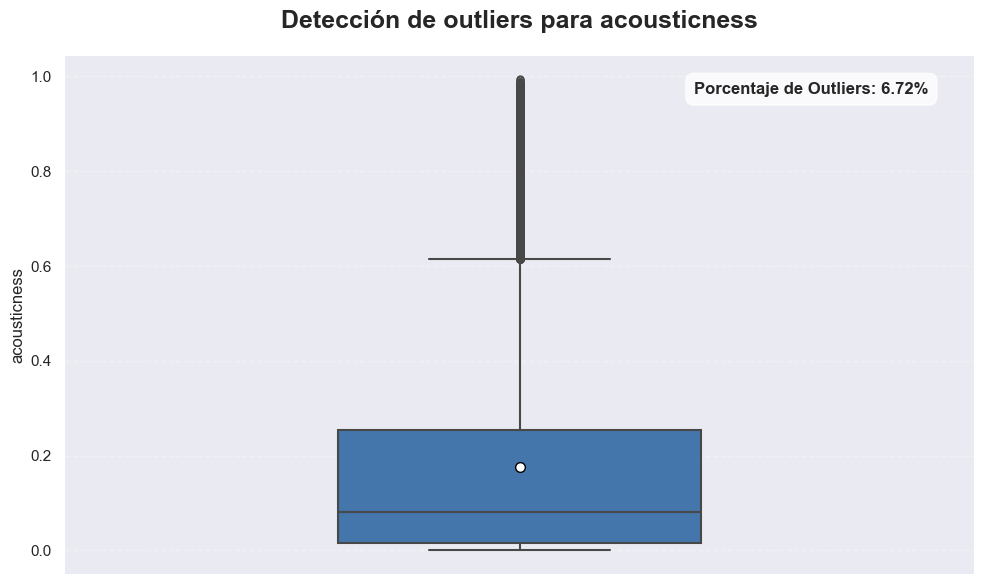

In [129]:
graficas.box_plot_para_atipicos(df, 'acousticness')

En este caso los outliers se pueden interpretar como la baja cantidad de canciones de las cual se tiene una alta calidad de confianza de que son acusticas, lo cual indica que pistas altamente acusticas son poco comunes en la muestra, a pesar del alto volumen de outliers no se considera eliminarlos por el fenomeno que estos describen y ser algo natural del negocio, permite reconocer que las canciones altamente acusticas son un nicho de mercado que puede ser peligroso para asegurar el exito comercial.